[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioRR-Tec/AprendizajeAutomatico/blob/master/Tema_2_AnalisisEstadistico/notebook/exercises/Practica_EDA_MaterialExtra.ipynb)

<h1><center> EDA (Análisis Exploratorio de Datos) y algo más... </center></h1>

Comparar varios tipos y atributos del siguiente Dataset con algunas imágenes y en el proceso podremos hacer un webscraping para mejorar un poco el conjunto de datos.

In [1]:
# Data manipulation libraries
import numpy as np 
import pandas as pd 

# Data visualisation 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping 
from bs4 import BeautifulSoup, Comment
from requests import get

## Reading the data
pokemon = pd.read_csv('https://raw.githubusercontent.com/MauricioRR-Tec/AprendizajeAutomatico/main/Tema_2_AnalisisEstadistico/data/Pokemon.csv')


### Datos - Preparación y Limpieza

Algo de exploración básica...


In [2]:
print(pokemon.head())
print(pokemon.info())

   #                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        8

In [3]:
pokemon

#                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire     NaN    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0         65       65     45           1      False  
1         80       80     60           1      False  
2        100      100     80           1      False  
3        122      120     80           1      False  
4         60       50     65           1      False  
..       ...      ...    ...         ...        ...  
795      100      150     50           6       True  
796      160      110    110           6       True  
797      150      130     70           6       True  
798      170      130     80           6       True  
799      130       90     70           6       True  

[800 rows x 13 columns]

In [4]:
# Desechar #
pokemon.drop(['#'], axis = 'columns', inplace = True)

# Sólo trabajaremos con la generación 1 y 2 .... vean que en este dataset hay hasta la 6ta gen...
my_pokemon = pokemon[pokemon.Generation.isin([1, 2])].copy()
my_pokemon.Generation.unique()
my_pokemon.shape

(272, 12)

Posiblemente podamos encontrar repetidos dadas las caracteristicas de algunos de los datos que tenemos en este conjunto...

In [5]:
print('There are ',my_pokemon.duplicated('Name').sum(), 'duplicated names in the dataset, so it must be something else\n')
print(my_pokemon.loc[(my_pokemon.Generation == 1) & (my_pokemon.Legendary == True), 'Name'],  '''\nAha! We didn't have MEGA stuff back in my day. Let's exclude those\n''')

There are  0 duplicated names in the dataset, so it must be something else

156               Articuno
157                 Zapdos
158                Moltres
162                 Mewtwo
163    MewtwoMega Mewtwo X
164    MewtwoMega Mewtwo Y
Name: Name, dtype: object 
Aha! We didn't have MEGA stuff back in my day. Let's exclude those



Filtremos aquellos que tienen palabras extra...

In [6]:
mega_filter = (my_pokemon.Name.str.contains('Mega ')) #Put a space there to exclude meganium which is a legit second generation pokemon
my_pokemon = my_pokemon[~mega_filter]
print(my_pokemon.groupby('Generation').size(),  '\nOk now everything matches my expectations!')

Generation
1    151
2    100
dtype: int64 
Ok now everything matches my expectations!


¡Bien! ¡Tenemos los 251 Pokémon ahora como esperábamos! Intentemos explorar un poco los atributos para ver en términos generales cómo se relacionan entre sí.

### Atributos de Pokémon y cómo se relacionan entre sí

Como tenemos 251 Pokémon y 6 atributos para cada uno de ellos, pensé que haría un desglose de cómo se relacionan entre sí.
¿Los Pokémon con mayor defensa también tienen un mayor ataque? ¿Los Pokémon rápidos también son buenos defensivamente?
Con ese fin, usaremos un par de cuadrículas de Seaborn. Es una cuadrícula bastante personalizable donde puede mapear diferentes tipos de parcelas en el triángulo superior, triángulo inferior y ejes diagonales.
La figura producida tiene tres tramas:

    Triángulo superior -> Diagrama de dispersión para cada pokemon con naranja que indica pokemon legendario (diagrama de dispersión de Seaborn)
    Diagonal -> Gráfico de densidad de kernel para cada atributo (Seabon kdplot)
    Triángulo inferior -> Gráfico de dispersión con un ajuste de modelo de regresión lineal (gráfico de reglaje de Seaborn)

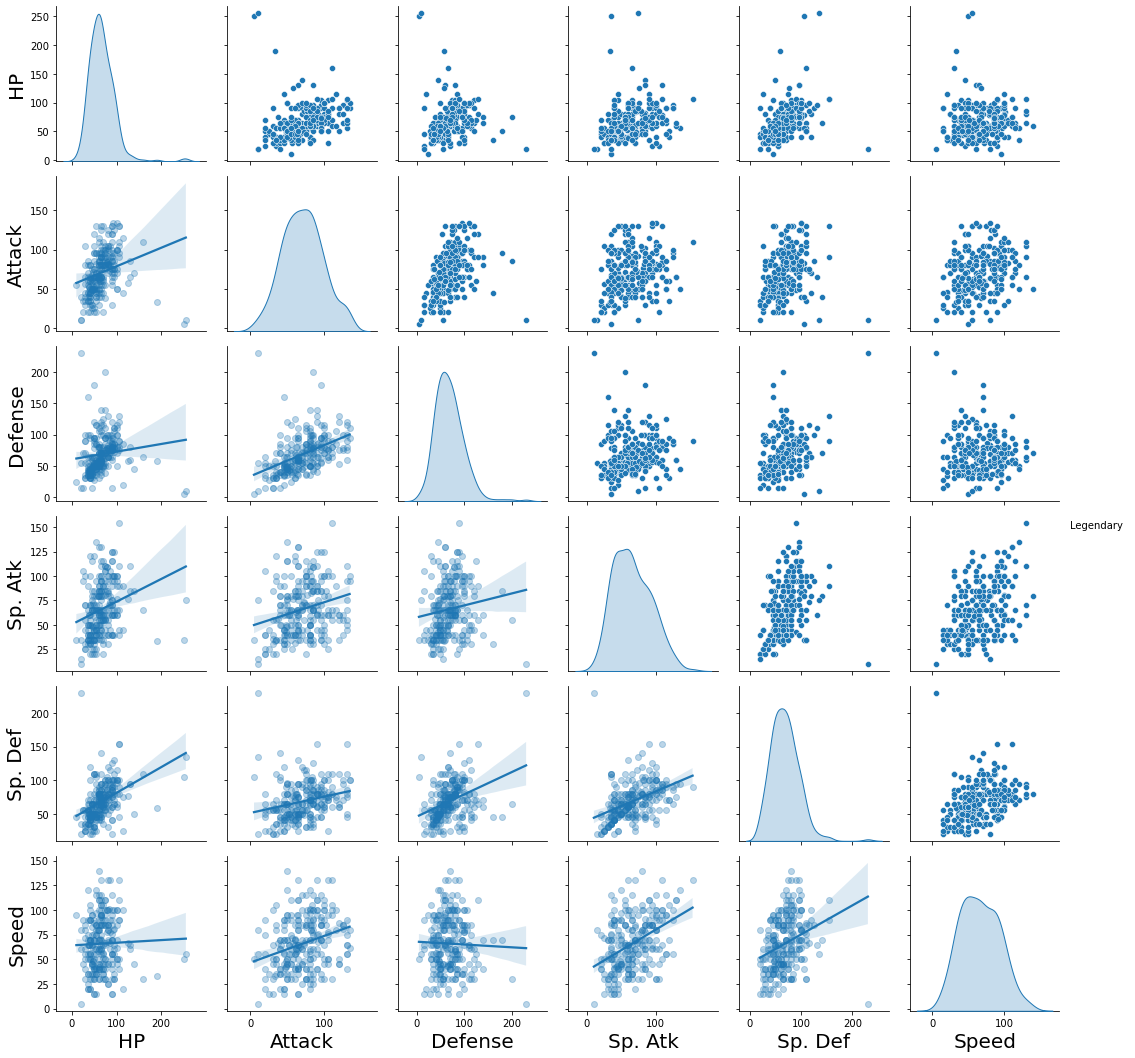

In [7]:
def my_pairgrid(input_df):
    mpl.rcParams["axes.labelsize"] = 20 #Increases the axis titles and the legend size
    g = sns.PairGrid(input_df, vars=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
    g = g.map_diag(sns.kdeplot, shade=True)
    g = g.map_lower(sns.regplot, scatter_kws={'alpha':0.3})
    g.hue_vals = input_df["Legendary"]
    g.hue_names = input_df["Legendary"].unique()
    g.palette = sns.color_palette("Set2", len(g.hue_names))
    g = g.map_upper(sns.scatterplot).add_legend(title='Legendary', fontsize= 14)
    return(g)
_ = my_pairgrid(my_pokemon)

Así que analicemos algunos hallazgos de este cuadro general:

    Los Pokémon legendarios están en el extremo superior del espectro para la mayoría de atributos.
    Puedo ver algunos signos de una relación positiva entre Ataque y Defensa, Sp.Def y HP, Speed ​​y Attack, así como Speed ​​y Sp.Atk
    La velocidad parece ser el atributo menos concentrado entre los 6


---

### Correlación entre atributos

Si bien el primer gráfico fue útil, quizás una mejor manera de visualizar la correlación entre atributos es un mapa de calor con un azul más fuerte que indica una correlación más alta.



In [8]:
my_pokemon

Name   Type 1  Type 2  Total   HP  Attack  Defense  Sp. Atk  \
0     Bulbasaur    Grass  Poison    318   45      49       49       65   
1       Ivysaur    Grass  Poison    405   60      62       63       80   
2      Venusaur    Grass  Poison    525   80      82       83      100   
4    Charmander     Fire     NaN    309   39      52       43       60   
5    Charmeleon     Fire     NaN    405   58      64       58       80   
..          ...      ...     ...    ...  ...     ...      ...      ...   
266     Pupitar     Rock  Ground    410   70      84       70       65   
267   Tyranitar     Rock    Dark    600  100     134      110       95   
269       Lugia  Psychic  Flying    680  106      90      130       90   
270       Ho-oh     Fire  Flying    680  106     130       90      110   
271      Celebi  Psychic   Grass    600  100     100      100      100   

     Sp. Def  Speed  Generation  Legendary  
0         65     45           1      False  
1         80     60           1      False  
2        100     80           1      False  
4         50     65           1      False  
5         65     80           1      False  
..       ...    ...         ...        ...  
266       70     51           2      False  
267      100     61           2      False  
269      154    110           2       True  
270      154     90           2       True  
271      100    100           2      False  

[251 rows x 12 columns]

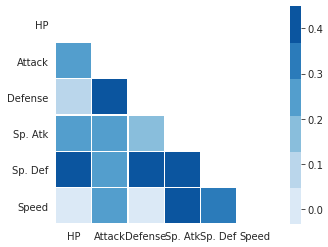

In [9]:
my_corr = my_pokemon.loc[:, 'HP':'Speed'].corr() 
mask = np.zeros_like(my_corr) 
mask[np.triu_indices_from(mask)] = True ## This part is to blank out the upper diagonal
with sns.axes_style("white"):
     ax = sns.heatmap(my_corr, mask=mask, square=True, cmap=sns.color_palette("Blues"), vmax=np.max(np.sort(my_corr.values)[:,-2]), linewidths=0.3)

# Análisis de atributos por pokemon y tipo

Hagamos un análisis de cómo los atributos varían con el tipo.
Mi primera idea fue usar un Seaborn Swarmplot ya que no tenemos tantos datos que estarán superpoblados.


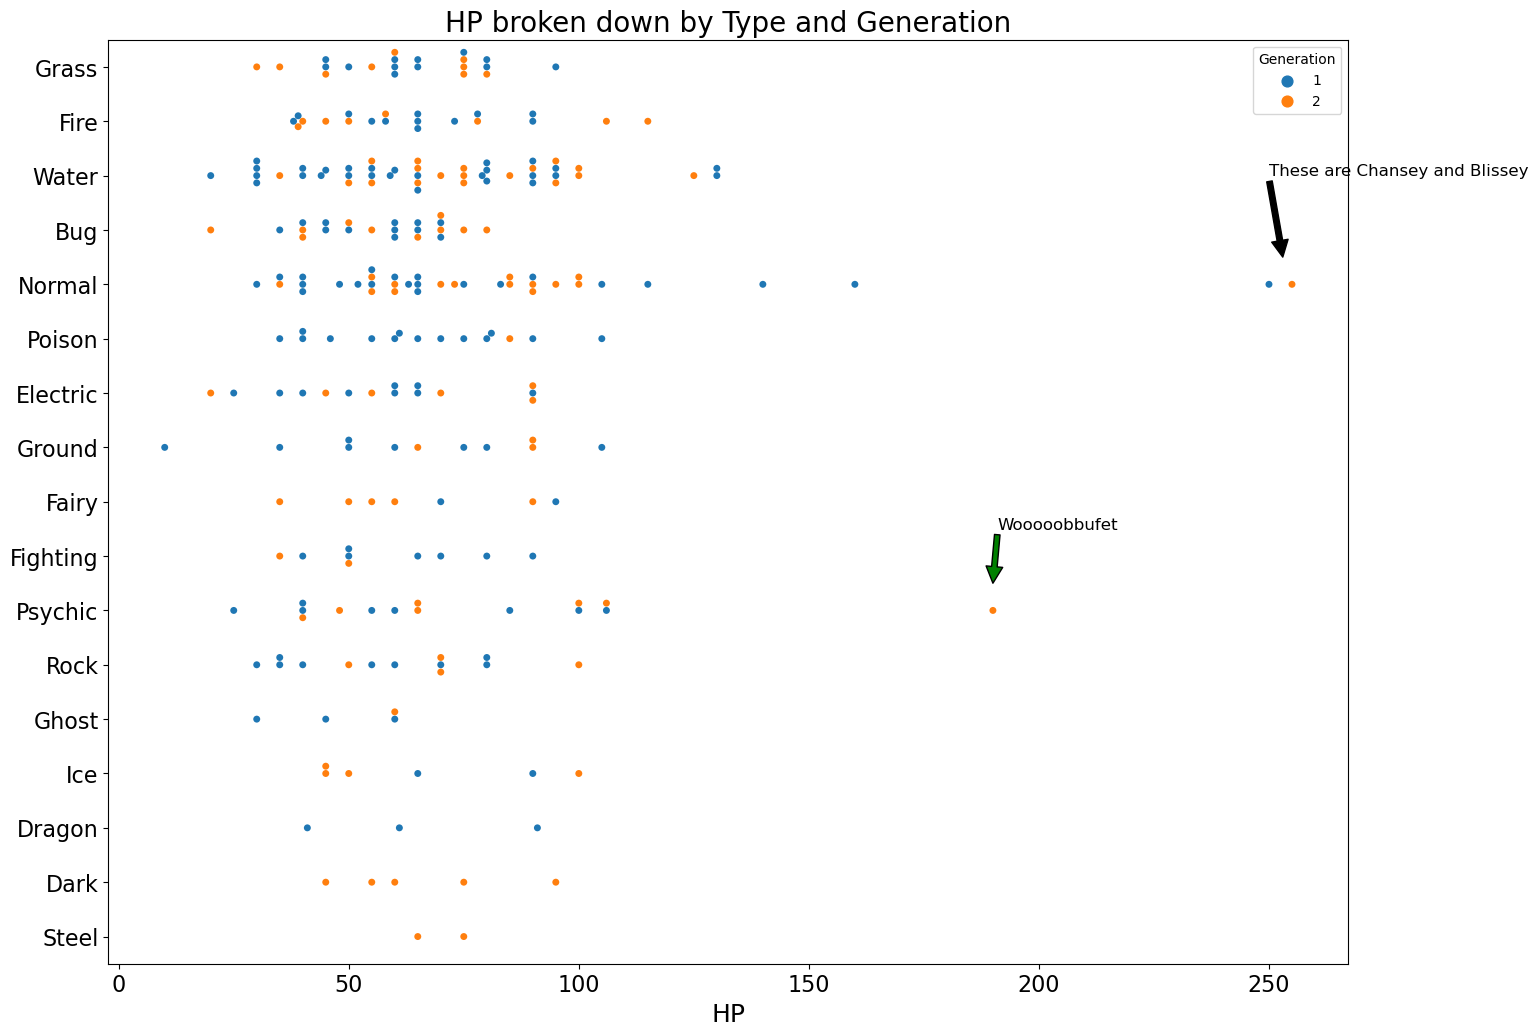

In [10]:
sns.reset_defaults()
plt.figure(figsize=(16,12))
g = sns.swarmplot(x='HP', y='Type 1', hue = 'Generation', data=my_pokemon)
g.yaxis.label.set_visible(False)
g.set_title('HP broken down by Type and Generation')
_ = g.annotate('These are Chansey and Blissey', xy=(253, 3.5), xytext = (250, 2), fontsize = 12, arrowprops=dict(facecolor='black') )
_ = g.annotate('Wooooobbufet', xy=(190, 9.5), xytext = (191, 8.5), fontsize = 12, arrowprops=dict(facecolor='green'))
g.title.set_fontsize(20)
g.xaxis.label.set_fontsize(18)
g.tick_params(axis='x', labelsize=16)
g.tick_params(axis='y', labelsize=16)

Honestamente, el gráfico parece distraer algo, no puedo distinguir mucho... además de los valores atípicos, notamos que hay un tipo de hada. Este no fue el caso en Gens 1 y 2, ¡los Pokémon de hadas eran Pokémon normales!

In [11]:
my_pokemon.loc[my_pokemon['Type 1'] == "Fairy", 'Type 1'] = 'Normal'
my_pokemon.loc[my_pokemon['Type 2'] == "Fairy", 'Type 2'] = np.nan

In [12]:
def attr_per_type(input_df, y_attr, hue_attr):
    mpl.rcParams["font.size"] = 18
    f, axes = plt.subplots(2, 3, figsize=(20, 20), sharey=True, sharex=True)
    #f.tight_layout()
    poke_attributes = ['HP', 'Defense', 'Sp. Def', 'Speed', 'Attack', 'Sp. Atk']
    counter = 0
    #axes[0,1].tick_params(labelleft=False)
    for row in range(2):
        for col in range(3):
            sns.boxplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], showfliers=False)
            sns.swarmplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], hue = hue_attr, palette=['black', 'orange'])
            axes[row, col].set_title(axes[row, col].get_xlabel())
            axes[row, col].xaxis.label.set_visible(False)
            axes[row, col].get_legend().remove()
            counter += 1
            if (col == 0):
                axes[row, col].yaxis.label.set_visible(False)
                continue
            axes[row, col].yaxis.set_visible(False)
    return(f, axes)


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the mar

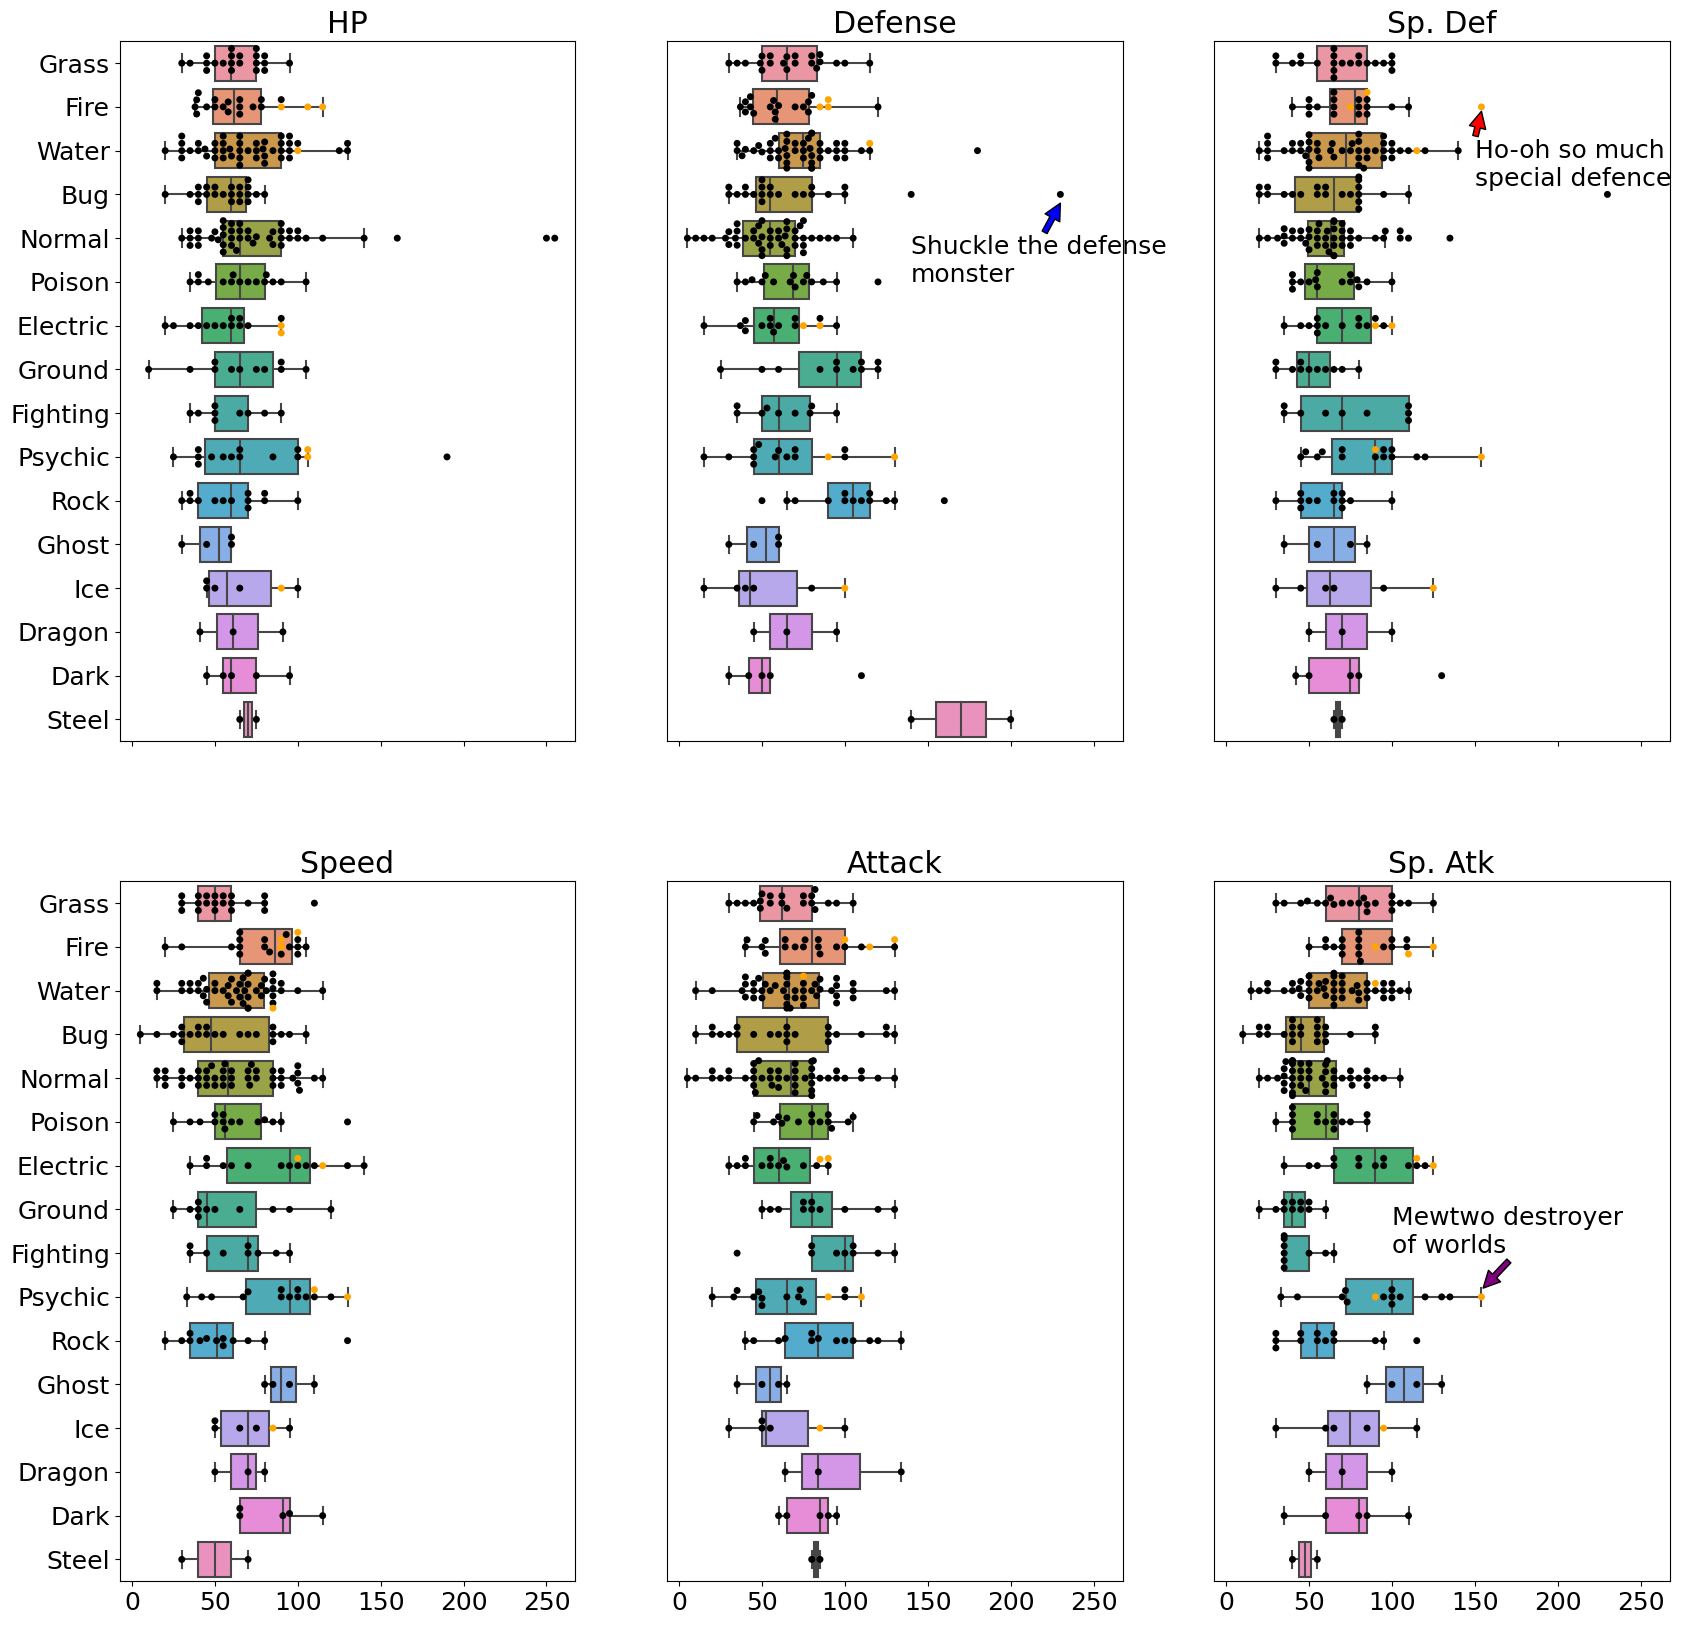

In [13]:
(f, axes) = attr_per_type(my_pokemon, 'Type 1', 'Legendary')
_ = axes[0, 1].annotate('Shuckle the defense \nmonster', xy=(230, 3.2), xytext = (140, 5), arrowprops=dict(facecolor='blue'))
_ = axes[0, 2].annotate('Ho-oh so much \nspecial defence', xy=(154, 1.1), xytext=(150, 2.8), arrowprops=dict(facecolor='red'))
_ = axes[1, 2].annotate('Mewtwo destroyer \nof worlds', xy=(155, 8.8), xytext= (100, 8), arrowprops=dict(facecolor='purple'))

Muy bien, esto se ve mucho mejor! El problema con el conjunto de datos actual es que incluye Pokémon de menor evolución. Por ejemplo, Charmander, Charmeleon y Charizard están todos incluidos. Preferiría que solo se incluyera el último Pokémon de evolución porque la selección se realiza principalmente en función de esos. Tratemos de solucionar este problema raspando el árbol de evolución de Pokémon del sitio web de pokemondb. 

Voy a desglosar cada paso para que sea más comprensible.
---

### Web scraping para mejorar nuestro conjunto de datos

**Paso 1: encontrar la URL**

El sitio web que elegí es el sitio web de pokemondb que enumera las evoluciones de todos los Pokémon en esta forma:

![img](https://i.postimg.cc/qR8yX0qW/Pika.png)


In [14]:
poke_url = 'https://pokemondb.net/evolution#evo-g2'
response = get(poke_url) 
html_soup = BeautifulSoup(response.text, 'html.parser') ## Getting the html into python

**Paso 2: examinar el HTML de la página y extraer los datos**

Ahora que tenemos el HTML, tenemos que examinar dónde se encuentra exactamente la información que queremos. Podemos utilizar las herramientas de desarrollo de Google Chrome para ver qué parte del árbol HTML nos interesa.

![img](https://i.postimg.cc/qRf8WwFf/Pika-HTML.png)



In [15]:
infocard = html_soup.find_all('div', {'class' : 'infocard-list-evo'})

**Paso 3: localizar y extraer toda la información útil en el HTML**

Ahora que hemos seleccionado todos los divs, necesitamos extraer la información que nos sea útil. Me gustaría obtener la siguiente información:

    La evolución es el pokemon (1º, 2º, etc.)
    El número de Pokémon (lo necesitaremos en el futuro para filtrar)
    El texto pequeño debajo del pokemon (nuevamente, esto se usará para filtrar)
    El nombre de pokemon

Toda la información que queremos se puede encontrar en el intervalo con la clase 'infocard-lg-data text-muted' como se puede ver en la captura de pantalla a continuación:

![img](https://i.postimg.cc/yxh1vgJp/Info-Pic.png)

Solo necesitamos extraer el primer pequeño (número de pokemon), el segundo pequeño (nombre de pokemon) y la etiqueta a con la clase 'ent-name' que tiene el texto pequeño debajo del pokemon.

También utilizo enumerate para crear un índice de la evolución del pokemon. Entonces, por ejemplo, en los casos simples (Charmander -> Charmeleon -> Charizard) con enumerate logro darle a Charmander el número 1, Charmeleon el número 2 y Charizard el número 3.

Desafortunadamente, esto falla estrepitosamente para los casos complejos (como el de Pikatchu) pero trataremos esto en un paso posterior.

In [16]:
raw = []
for chain in infocard:
    raw.append(([(i, x.find('small').getText(), x.find_all('small')[1].getText(), x.find('a', {'class':'ent-name'}).getText(), ) for i, x in enumerate(list(chain.find_all('span', {'class':'infocard-lg-data text-muted'})), 1)]))

raw[:4] ## Our list contains touple lists with the evolution branch of each pokemon. We keep that in mind for our future processing

[[(1, '#001', 'Grass · Poison', 'Bulbasaur'),
  (2, '#002', 'Grass · Poison', 'Ivysaur'),
  (3, '#003', 'Grass · Poison', 'Venusaur')],
 [(1, '#004', 'Fire', 'Charmander'),
  (2, '#005', 'Fire', 'Charmeleon'),
  (3, '#006', 'Fire · Flying', 'Charizard')],
 [(1, '#007', 'Water', 'Squirtle'),
  (2, '#008', 'Water', 'Wartortle'),
  (3, '#009', 'Water', 'Blastoise')],
 [(1, '#010', 'Bug', 'Caterpie'),
  (2, '#011', 'Bug', 'Metapod'),
  (3, '#012', 'Bug · Flying', 'Butterfree')]]

In [17]:
raw

[[(1, '#001', 'Grass · Poison', 'Bulbasaur'),
  (2, '#002', 'Grass · Poison', 'Ivysaur'),
  (3, '#003', 'Grass · Poison', 'Venusaur')],
 [(1, '#004', 'Fire', 'Charmander'),
  (2, '#005', 'Fire', 'Charmeleon'),
  (3, '#006', 'Fire · Flying', 'Charizard')],
 [(1, '#007', 'Water', 'Squirtle'),
  (2, '#008', 'Water', 'Wartortle'),
  (3, '#009', 'Water', 'Blastoise')],
 [(1, '#010', 'Bug', 'Caterpie'),
  (2, '#011', 'Bug', 'Metapod'),
  (3, '#012', 'Bug · Flying', 'Butterfree')],
 [(1, '#013', 'Bug · Poison', 'Weedle'),
  (2, '#014', 'Bug · Poison', 'Kakuna'),
  (3, '#015', 'Bug · Poison', 'Beedrill')],
 [(1, '#016', 'Normal · Flying', 'Pidgey'),
  (2, '#017', 'Normal · Flying', 'Pidgeotto'),
  (3, '#018', 'Normal · Flying', 'Pidgeot')],
 [(1, '#019', 'Normal', 'Rattata'), (2, '#020', 'Normal', 'Raticate')],
 [(1, '#019', 'Alolan Rattata', 'Rattata'),
  (2, '#020', 'Alolan Raticate', 'Raticate')],
 [(1, '#021', 'Normal · Flying', 'Spearow'),
  (2, '#022', 'Normal · Flying', 'Fearow')],
 [(1

**Paso 4: limpieza del conjunto de datos**

Ahora que hemos extraído los datos, definitivamente necesitamos hacer algunos filtros:

    Eliminar todos los Pokémon que tienen 'alolan' en su nombre, ya que son de generaciones más nuevas, supongo.
    Elimina todos los Pokémon con un número superior a 251, ya que estos son nuevamente de generaciones más nuevas.
    Elimine todas las entradas restantes que tengan 1 o menos entradas de la lista

In [18]:
#And what better way to do all this than list comprehensions! 
step_1 = [[elem for elem in branch_list if 'Alol' not in elem[2]] for branch_list in raw] ## Remove all touples that contain 'Alol' in the small text (removing the second Raichu in our example)
step_2 = [[elem for elem in branch_list if int(elem[1][1:]) <= 251] for branch_list in step_1] ## Remove all pokemon that are after Gen 2 (Number > 251) 
step_3 = [elem for elem in step_2 if len(elem) > 1] ##Remove entries that have a length of 1 or less (remove leftovers that are not actual branches in Gens 1 & 2)

**Paso 5: mejorar nuestro conjunto de datos existente**

Para el análisis me gustaría poder decir qué Pokémon son la última evolución de cada rama y qué Pokémon no tienen evolución (y por lo tanto no se incluyeron en la lista en absoluto). Por ejemplo: Charmander es el primero en el árbol de evolución Charmander-Charmeleon-Charizard y me gustaría excluirlo del análisis. Snorlax por otro lado no tiene evolución y me gustaría incluirlo en el análisis.

Por tanto, me gustaría crear 2 listas, una con todos los pokémon que pertenecen a una rama de evolución y otra con pokémon que son los últimos de una rama de evolución.



In [19]:
has_evolution = [[elem[3] for elem in branch_list] for branch_list in step_3] ## Extract all pokemon that in the raw list
has_evolution = sum(has_evolution, []) ## 'Un-tupple' them -- This is not the optimal way to do this but I find it really really cool and for such a small list it doesn't matter

In [20]:
last_evolutions  = [x[-1] for x in step_3] ## Take the last entry into each element list
last_evolutions.extend([x[-2] for x in step_3 if x[-1][0] == 4]) # The ones that have 2 end evolutions like Politoed and Poliwrath

## This is the eevee and hitmontop section as they have 5 and 3 final evolutions respecitvely
eevee_and_hitmon = [x[1:] for x in step_3 if (x[0][3] == 'Tyrogue') or (x[0][3] ==  'Eevee')]
eevee_and_hitmon = sum(eevee_and_hitmon, [])
last_evolutions.extend(eevee_and_hitmon)

last_evo_df = pd.DataFrame([[int(x[1][1:]), x[3]] for x in last_evolutions], columns=['Number', 'Pokemon'] )
last_evo_df = last_evo_df.drop_duplicates() ## Remove duplicates because some hitmontop and eevee evolutions have been added more than once in the process

Estamos al final del proceso, tenemos una lista de Pokémon que pertenecen a una rama de evolución y también tenemos una lista de Pokémon que son las últimas evoluciones. Sigamos adelante y actualicemos nuestro conjunto de datos inicial

In [21]:
my_pokemon['Has_evol'] = my_pokemon.Name.isin(has_evolution)
my_pokemon['Last_evol'] = my_pokemon.Name.isin(last_evo_df.Pokemon)
my_evolved_pokemon = my_pokemon.loc[(my_pokemon.Last_evol == True) | (my_pokemon.Has_evol == False)].copy()

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


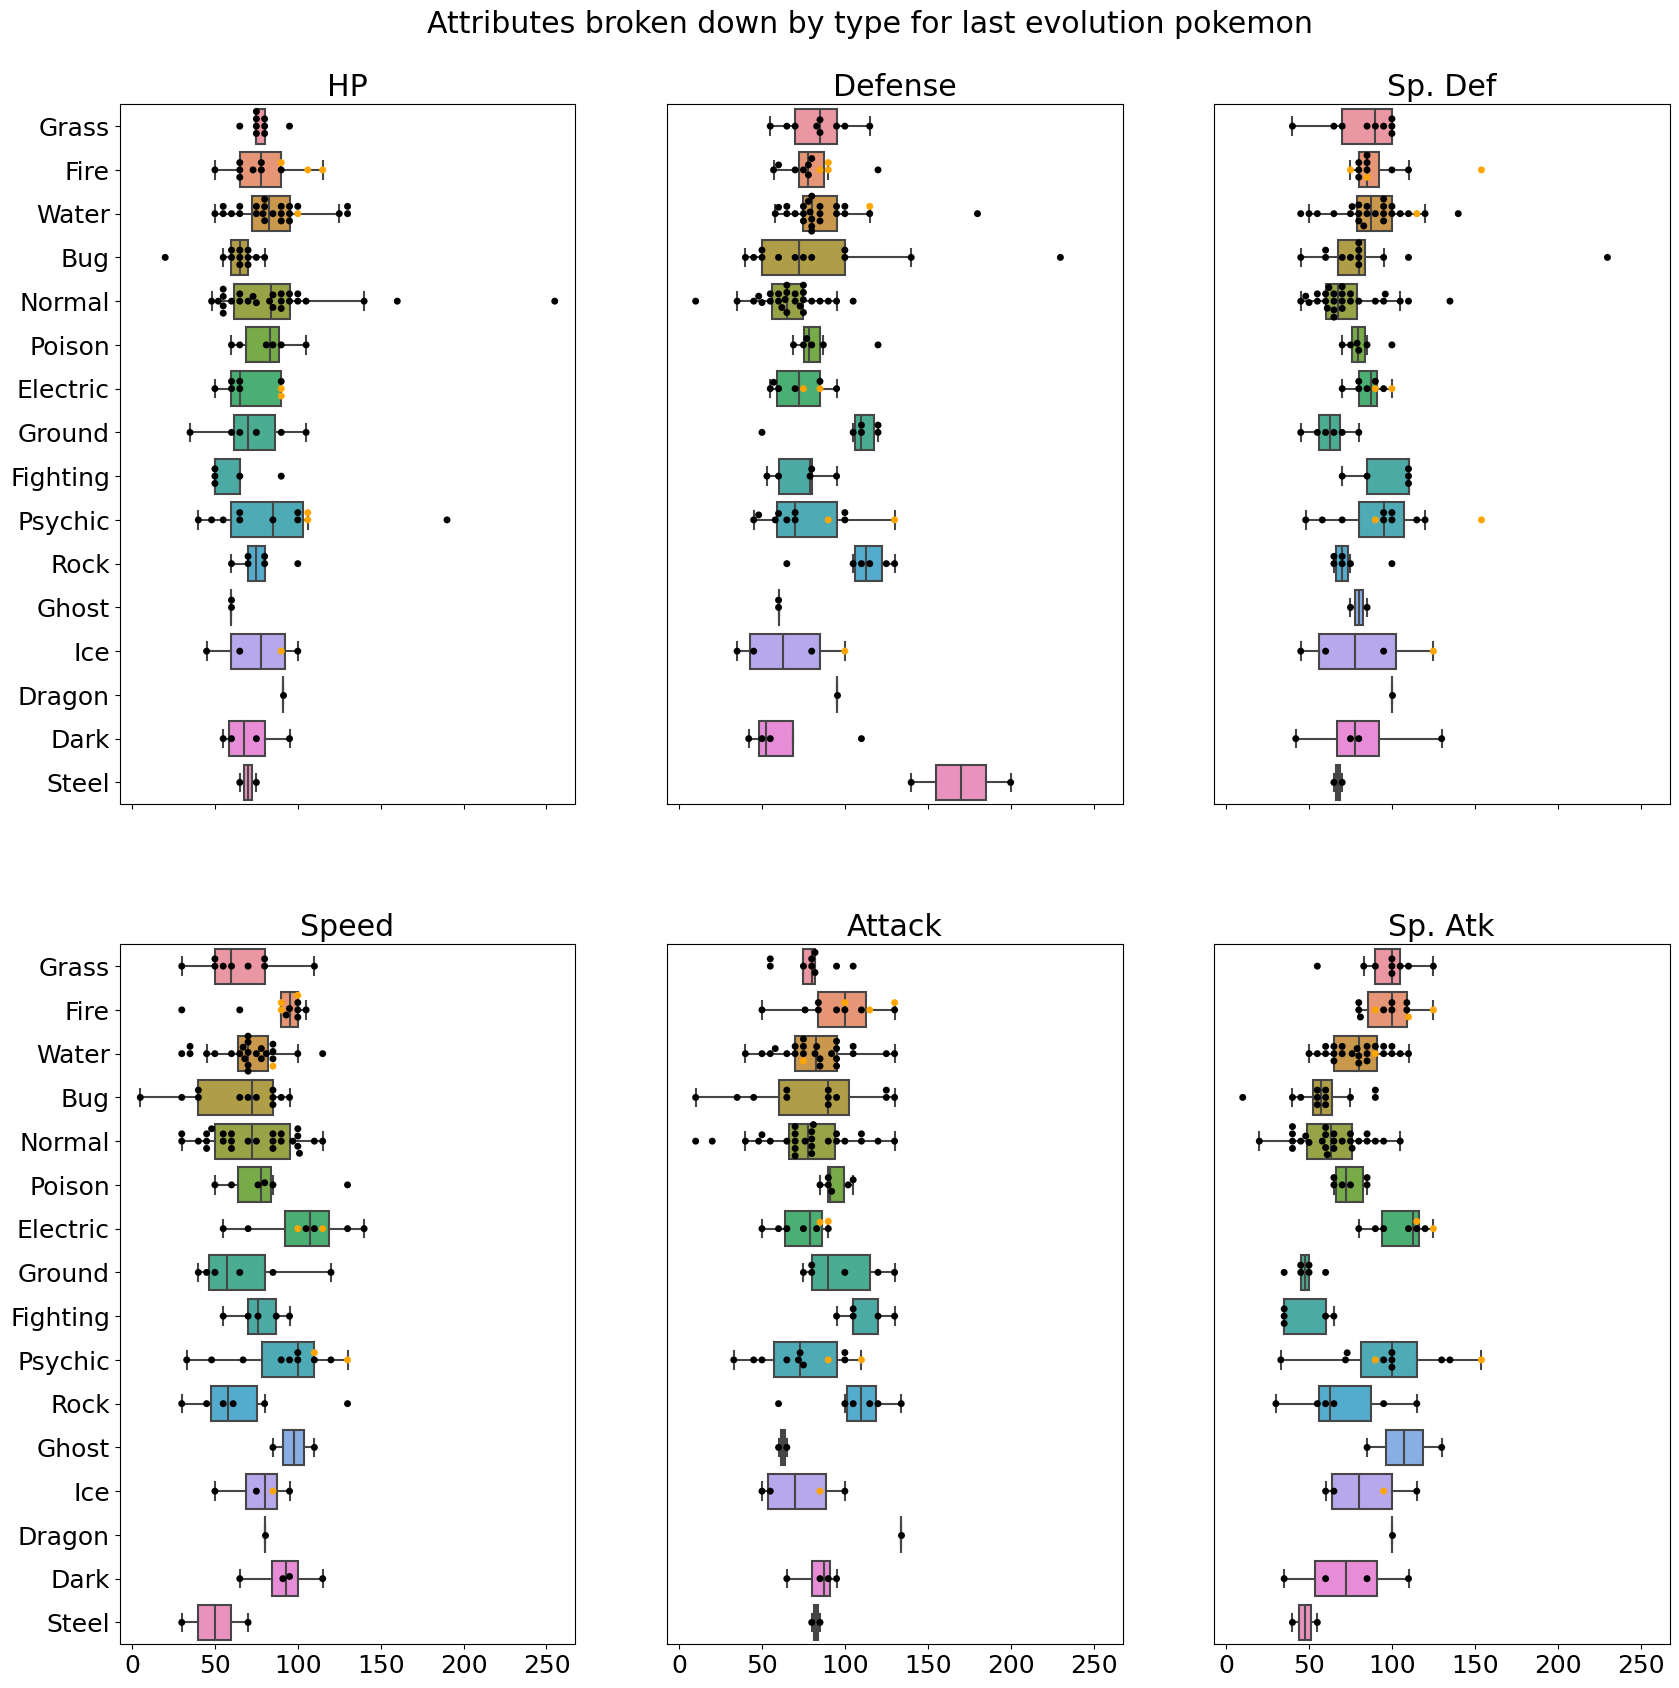

In [22]:
(f, axes) = attr_per_type(my_evolved_pokemon, 'Type 1', 'Legendary')
_ = f.suptitle('Attributes broken down by type for last evolution pokemon', va='center', y=0.92)

Estos son los Pokémon reales que podrían usarse en una batalla de Pokémon, ya que tener una evolución significa que tus estadísticas aumentarán y tendrás acceso a un grupo de movimientos más amplio.

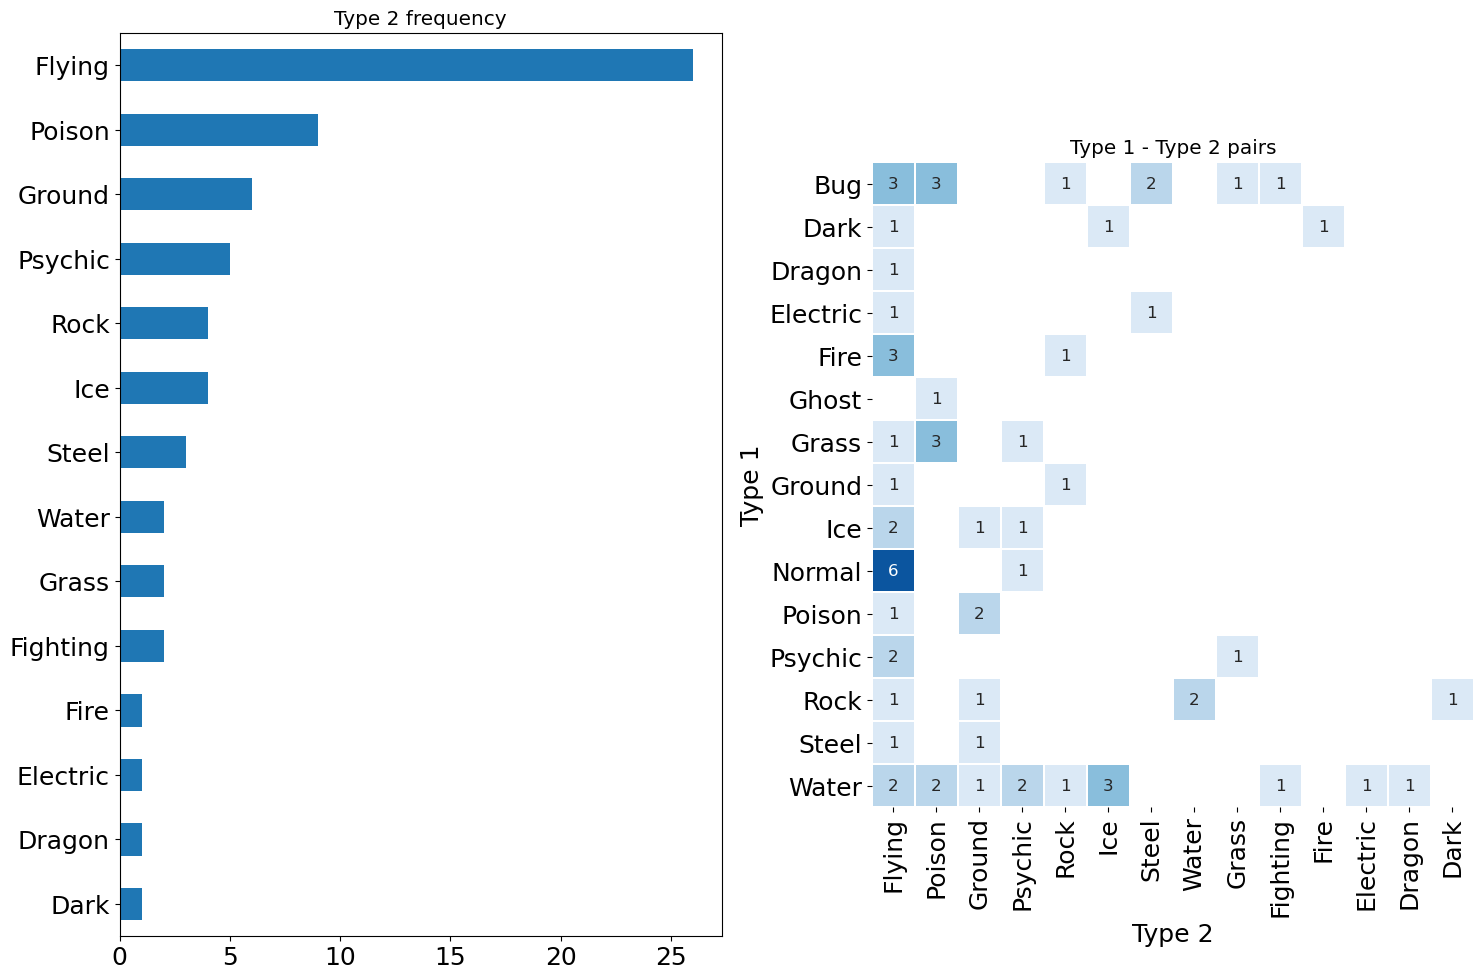

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
mpl.rcParams["font.size"] = 12

ax1 = my_evolved_pokemon.groupby('Type 2').size().sort_values().plot(kind='barh', ax=ax1)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 5))
ax1.axes.get_yaxis().get_label().set_visible(False)
_ = ax1.set_title('Type 2 frequency')

pivot_dat = my_evolved_pokemon.pivot_table(index='Type 1', columns='Type 2', aggfunc = 'size')
pivot_dat = pivot_dat[pivot_dat.sum().sort_values(ascending = False).index] #Reordering
ax2 = sns.heatmap(pivot_dat, annot=True, square=True, cmap=sns.color_palette("Blues"), cbar=False, linewidths=0.3, ax=ax2)
_ = ax2.set_title('Type 1 - Type 2 pairs')
fig.tight_layout()

In [24]:
my_evolved_pokemon['New type'] = my_evolved_pokemon['Type 1']
my_evolved_pokemon['Dual type'] = ~pd.isnull(my_pokemon['Type 2'])
dual_evolved_pokemon = my_evolved_pokemon.append(my_evolved_pokemon[my_evolved_pokemon['Dual type']==True], ignore_index=True)

#Change the second instance of the pokemon to have the second type
dual_evolved_pokemon.loc[dual_evolved_pokemon.duplicated(), 'New type'] = dual_evolved_pokemon.loc[dual_evolved_pokemon.duplicated(), 'Type 2'] 

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


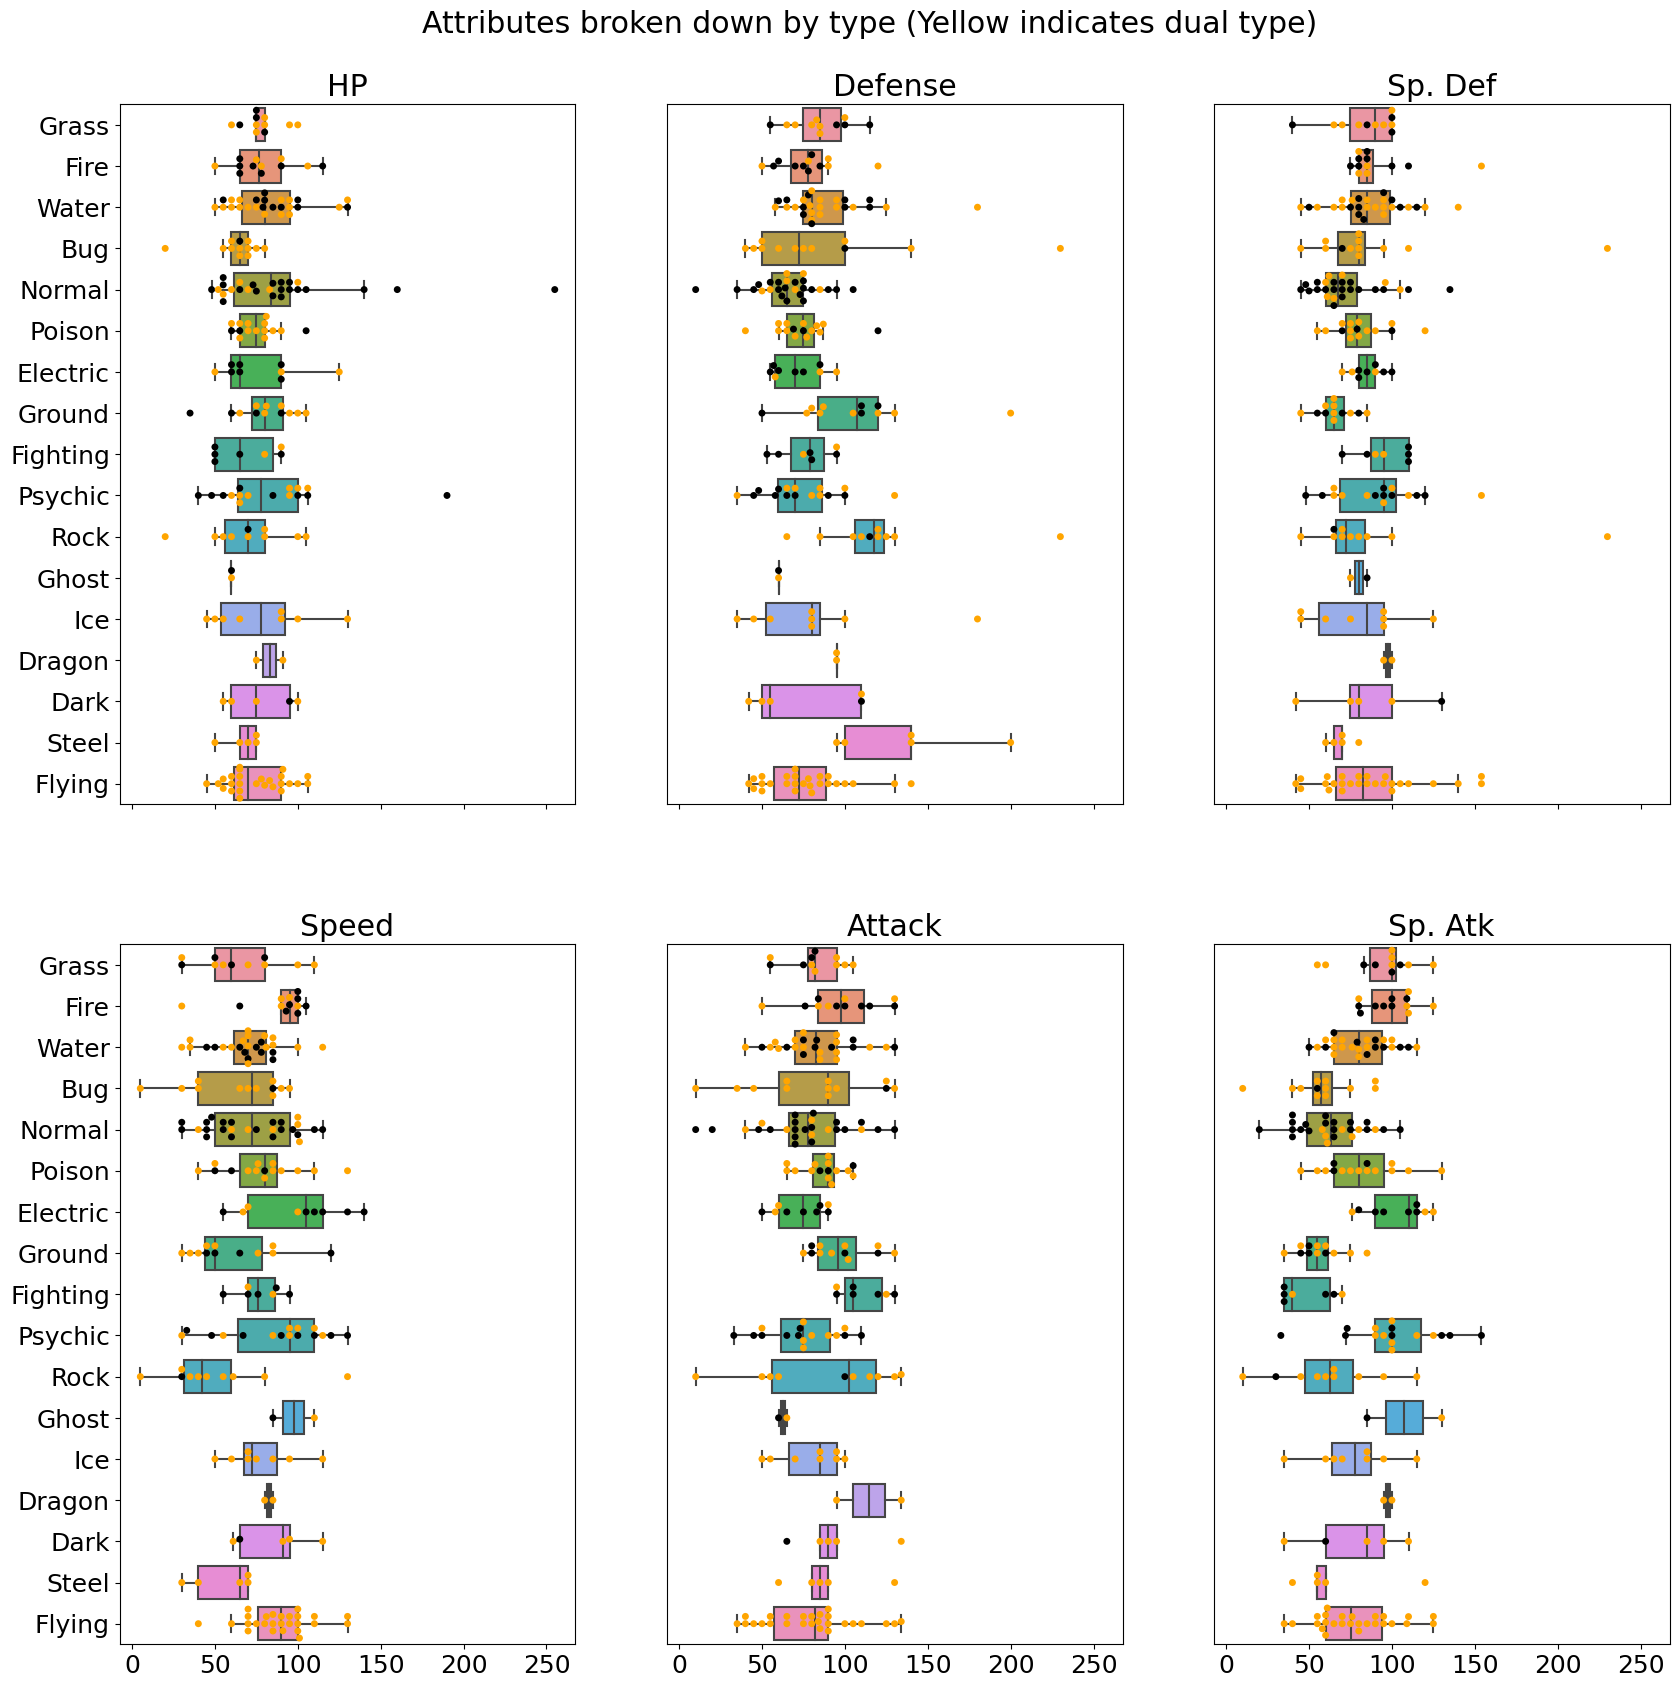

In [25]:
(f, axes) = attr_per_type(dual_evolved_pokemon, 'New type', 'Dual type')
_ = f.suptitle("Attributes broken down by type (Yellow indicates dual type)", va='center', y=0.92)

# Modelos para saber si son o no legendarios

In [26]:
my_pokemon.Legendary.unique()

array([False,  True])

In [27]:
X = my_pokemon.drop(columns =['Name', 'Type 1', 'Type 2', 'Generation', 'Legendary', 'Has_evol', 'Last_evol'])
y = my_pokemon['Legendary']

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y) # 80% y 20%

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

alg1 = LogisticRegression()
alg2 = SVC(kernel = 'rbf') #lineal , polinomial, radial basis fuction (gaussiano)
alg3 = RF()
alg4 = DT()

In [30]:
from sklearn.metrics import accuracy_score
alg1.fit(X_train, y_train) #Training the model

pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, alg1.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, alg1.predict(X_test))]})

Accurancy on Train  Accurancy on Test
0            0.984043           0.952381

In [31]:
alg2.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, alg2.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, alg2.predict(X_test))]})


Accurancy on Train  Accurancy on Test
0            0.973404           0.936508

In [32]:
alg3.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, alg3.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, alg3.predict(X_test))]})

Accurancy on Train  Accurancy on Test
0                 1.0           0.984127

In [33]:
alg4.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, alg4.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, alg4.predict(X_test))]})

Accurancy on Train  Accurancy on Test
0                 1.0                1.0

In [34]:
test = np.array([[720.0,120.0,120.0,120.0,120.0,120.0,120.0]])

In [35]:
alg1.predict(test)[0]

True

In [36]:
alg2.predict(test)[0]

False

In [37]:
alg3.predict(test)[0]

True

In [38]:
alg4.predict(test)[0]

True

### Implementando perceptrón

In [39]:
from sklearn.linear_model import Perceptron

In [40]:
# Un perceptrón con las siguientes características y deberán entrenarlo
ppn = Perceptron(eta0=0.001)
ppn.fit(X_train, y_train)

Perceptron(eta0=0.001)

In [41]:
# Ahora, debemos hacer la predicción...
y_pred = ppn.predict(X_test)

In [42]:
y_pred

array([ True, False,  True, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False])

In [43]:
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.75


In [44]:
ppn.predict(test)[0]

False

### Extender ejercicio para otras categorías usando pokedex_v2

In [45]:
pkdx = pd.read_csv('https://raw.githubusercontent.com/MauricioRR-Tec/AprendizajeAutomatico/main/Tema_2_AnalisisEstadistico/data/pokedex_v2.csv')

In [46]:
pkdx

pokedex_number                            Name    type_1  type_2  \
0                  1                       Bulbasaur     Grass  Poison   
1                  2                         Ivysaur     Grass  Poison   
2                  3                        Venusaur     Grass  Poison   
3                  3                   Mega Venusaur     Grass  Poison   
4                  4                      Charmander      Fire     NaN   
...              ...                             ...       ...     ...   
1023             888     Zacian Hero of Many Battles     Fairy     NaN   
1024             889        Zamazenta Crowned Shield  Fighting   Steel   
1025             889  Zamazenta Hero of Many Battles  Fighting     NaN   
1026             890                       Eternatus    Poison  Dragon   
1027             890             Eternatus Eternamax    Poison  Dragon   

      total_points   hp  attack  defense  sp_attack  sp_defense  speed  \
0              318   45      49       49         65          65     45   
1              405   60      62       63         80          80     60   
2              525   80      82       83        100         100     80   
3              625   80     100      123        122         120     80   
4              309   39      52       43         60          50     65   
...            ...  ...     ...      ...        ...         ...    ...   
1023           670   92     130      115         80         115    138   
1024           720   92     130      145         80         145    128   
1025           670   92     130      115         80         115    138   
1026           690  140      85       95        145          95    130   
1027          1125  255     115      250        125         250    130   

      generation     status  
0              1     Normal  
1              1     Normal  
2              1     Normal  
3              1     Normal  
4              1     Normal  
...          ...        ...  
1023           8  Legendary  
1024           8  Legendary  
1025           8  Legendary  
1026           8  Legendary  
1027           8  Legendary  

[1028 rows x 13 columns]

In [47]:
result = pd.merge(pokemon, pkdx, on=['Name'])

In [48]:
result

Name  Type 1  Type 2  Total   HP  Attack  Defense  Sp. Atk  \
0     Bulbasaur   Grass  Poison    318   45      49       49       65   
1       Ivysaur   Grass  Poison    405   60      62       63       80   
2      Venusaur   Grass  Poison    525   80      82       83      100   
3    Charmander    Fire     NaN    309   39      52       43       60   
4    Charmeleon    Fire     NaN    405   58      64       58       80   
..          ...     ...     ...    ...  ...     ...      ...      ...   
699     Noivern  Flying  Dragon    535   85      70       80       97   
700     Xerneas   Fairy     NaN    680  126     131       95      131   
701     Yveltal    Dark  Flying    680  126     131       95      131   
702     Diancie    Rock   Fairy    600   50     100      150      100   
703   Volcanion    Fire   Water    600   80     110      120      130   

     Sp. Def  Speed  ...  type_2  total_points   hp attack defense  sp_attack  \
0         65     45  ...  Poison           318   45     49      49         65   
1         80     60  ...  Poison           405   60     62      63         80   
2        100     80  ...  Poison           525   80     82      83        100   
3         50     65  ...     NaN           309   39     52      43         60   
4         65     80  ...     NaN           405   58     64      58         80   
..       ...    ...  ...     ...           ...  ...    ...     ...        ...   
699       80    123  ...  Dragon           535   85     70      80         97   
700       98     99  ...     NaN           680  126    131      95        131   
701       98     99  ...  Flying           680  126    131      95        131   
702      150     50  ...   Fairy           600   50    100     150        100   
703       90     70  ...   Water           600   80    110     120        130   

     sp_defense  speed  generation     status  
0            65     45           1     Normal  
1            80     60           1     Normal  
2           100     80           1     Normal  
3            50     65           1     Normal  
4            65     80           1     Normal  
..          ...    ...         ...        ...  
699          80    123           6     Normal  
700          98     99           6  Legendary  
701          98     99           6  Legendary  
702         150     50           6   Mythical  
703          90     70           6   Mythical  

[704 rows x 24 columns]

In [49]:
X = result[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = result['status']

In [50]:
X

Total   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
0      318   45      49       49       65       65     45
1      405   60      62       63       80       80     60
2      525   80      82       83      100      100     80
3      309   39      52       43       60       50     65
4      405   58      64       58       80       65     80
..     ...  ...     ...      ...      ...      ...    ...
699    535   85      70       80       97       80    123
700    680  126     131       95      131       98     99
701    680  126     131       95      131       98     99
702    600   50     100      150      100      150     50
703    600   80     110      120      130       90     70

[704 rows x 7 columns]

In [51]:
y

0         Normal
1         Normal
2         Normal
3         Normal
4         Normal
         ...    
699       Normal
700    Legendary
701    Legendary
702     Mythical
703     Mythical
Name: status, Length: 704, dtype: object

In [52]:
result.groupby('status').generation.describe()

count      mean       std  min  25%  50%  75%  max
status                                                           
Legendary       13.0  3.769231  1.589227  1.0  3.0  4.0  5.0  6.0
Mythical        11.0  4.000000  1.549193  1.0  3.5  4.0  5.0  6.0
Normal         660.0  3.263636  1.673740  1.0  2.0  3.0  5.0  6.0
Sub Legendary   20.0  3.150000  1.308877  1.0  2.0  3.0  4.0  5.0

In [53]:
!pip install imbalanced-learn

In [54]:
from imblearn.over_sampling import RandomOverSampler

Esto significa que si la clase mayoritaria tuviera 1000 ejemplos y la clase minoritaria 100, esta estrategia sobremuestrearía la clase minoritaria para que tenga 1000 ejemplos.

In [55]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [56]:
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

In [57]:
from imblearn.under_sampling import RandomUnderSampler

Por ejemplo, un conjunto de datos con 1000 ejemplos en la clase mayoritaria y 100 ejemplos en la clase minoritaria se submuestreará de modo que ambas clases tengan 100 ejemplos en el conjunto de datos de entrenamiento transformado.


In [58]:
undersample = RandomUnderSampler(sampling_strategy='majority')

Luego, la transformación puede ajustarse y aplicarse a un conjunto de datos en un solo paso llamando a la función fit_resample () y pasando el conjunto de datos sin transformar como argumentos.

In [59]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o las diferencias en la precisión numérica. Considera ejecutar el ejemplo varias veces y compara el resultado promedio.

El modelo elegido y la configuración de remuestreo son arbitrarios, diseñados para proporcionar una plantilla que puede usar para probar el submuestreo con su conjunto de datos y algoritmo de aprendizaje en lugar de resolver de manera óptima el conjunto de datos sintéticos.

**Tipos comunes...**


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


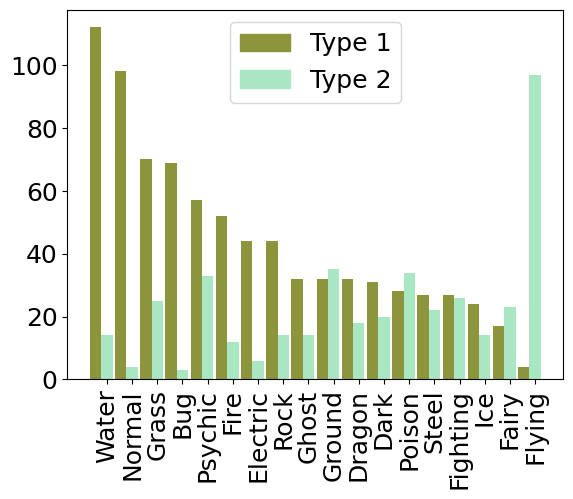

In [60]:
import matplotlib.patches as patches
vals1 = [pokemon['Type 1'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
vals2 = [pokemon['Type 2'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
inds = np.arange(len(pokemon['Type 1'].value_counts().index))
width = .45
color1 = np.random.rand(3)
color2 = np.random.rand(3)
handles = [patches.Patch(color=color1, label='Type 1'), patches.Patch(color=color2, label='Type 2')]
plt.bar(inds, vals1, width, color=color1)
plt.bar(inds+width, vals2, width, color=color2)
plt.gca().set_xticklabels(pokemon['Type 1'].value_counts().index)
plt.gca().set_xticks(inds+width)
plt.xticks(rotation=90)
plt.legend(handles=handles)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

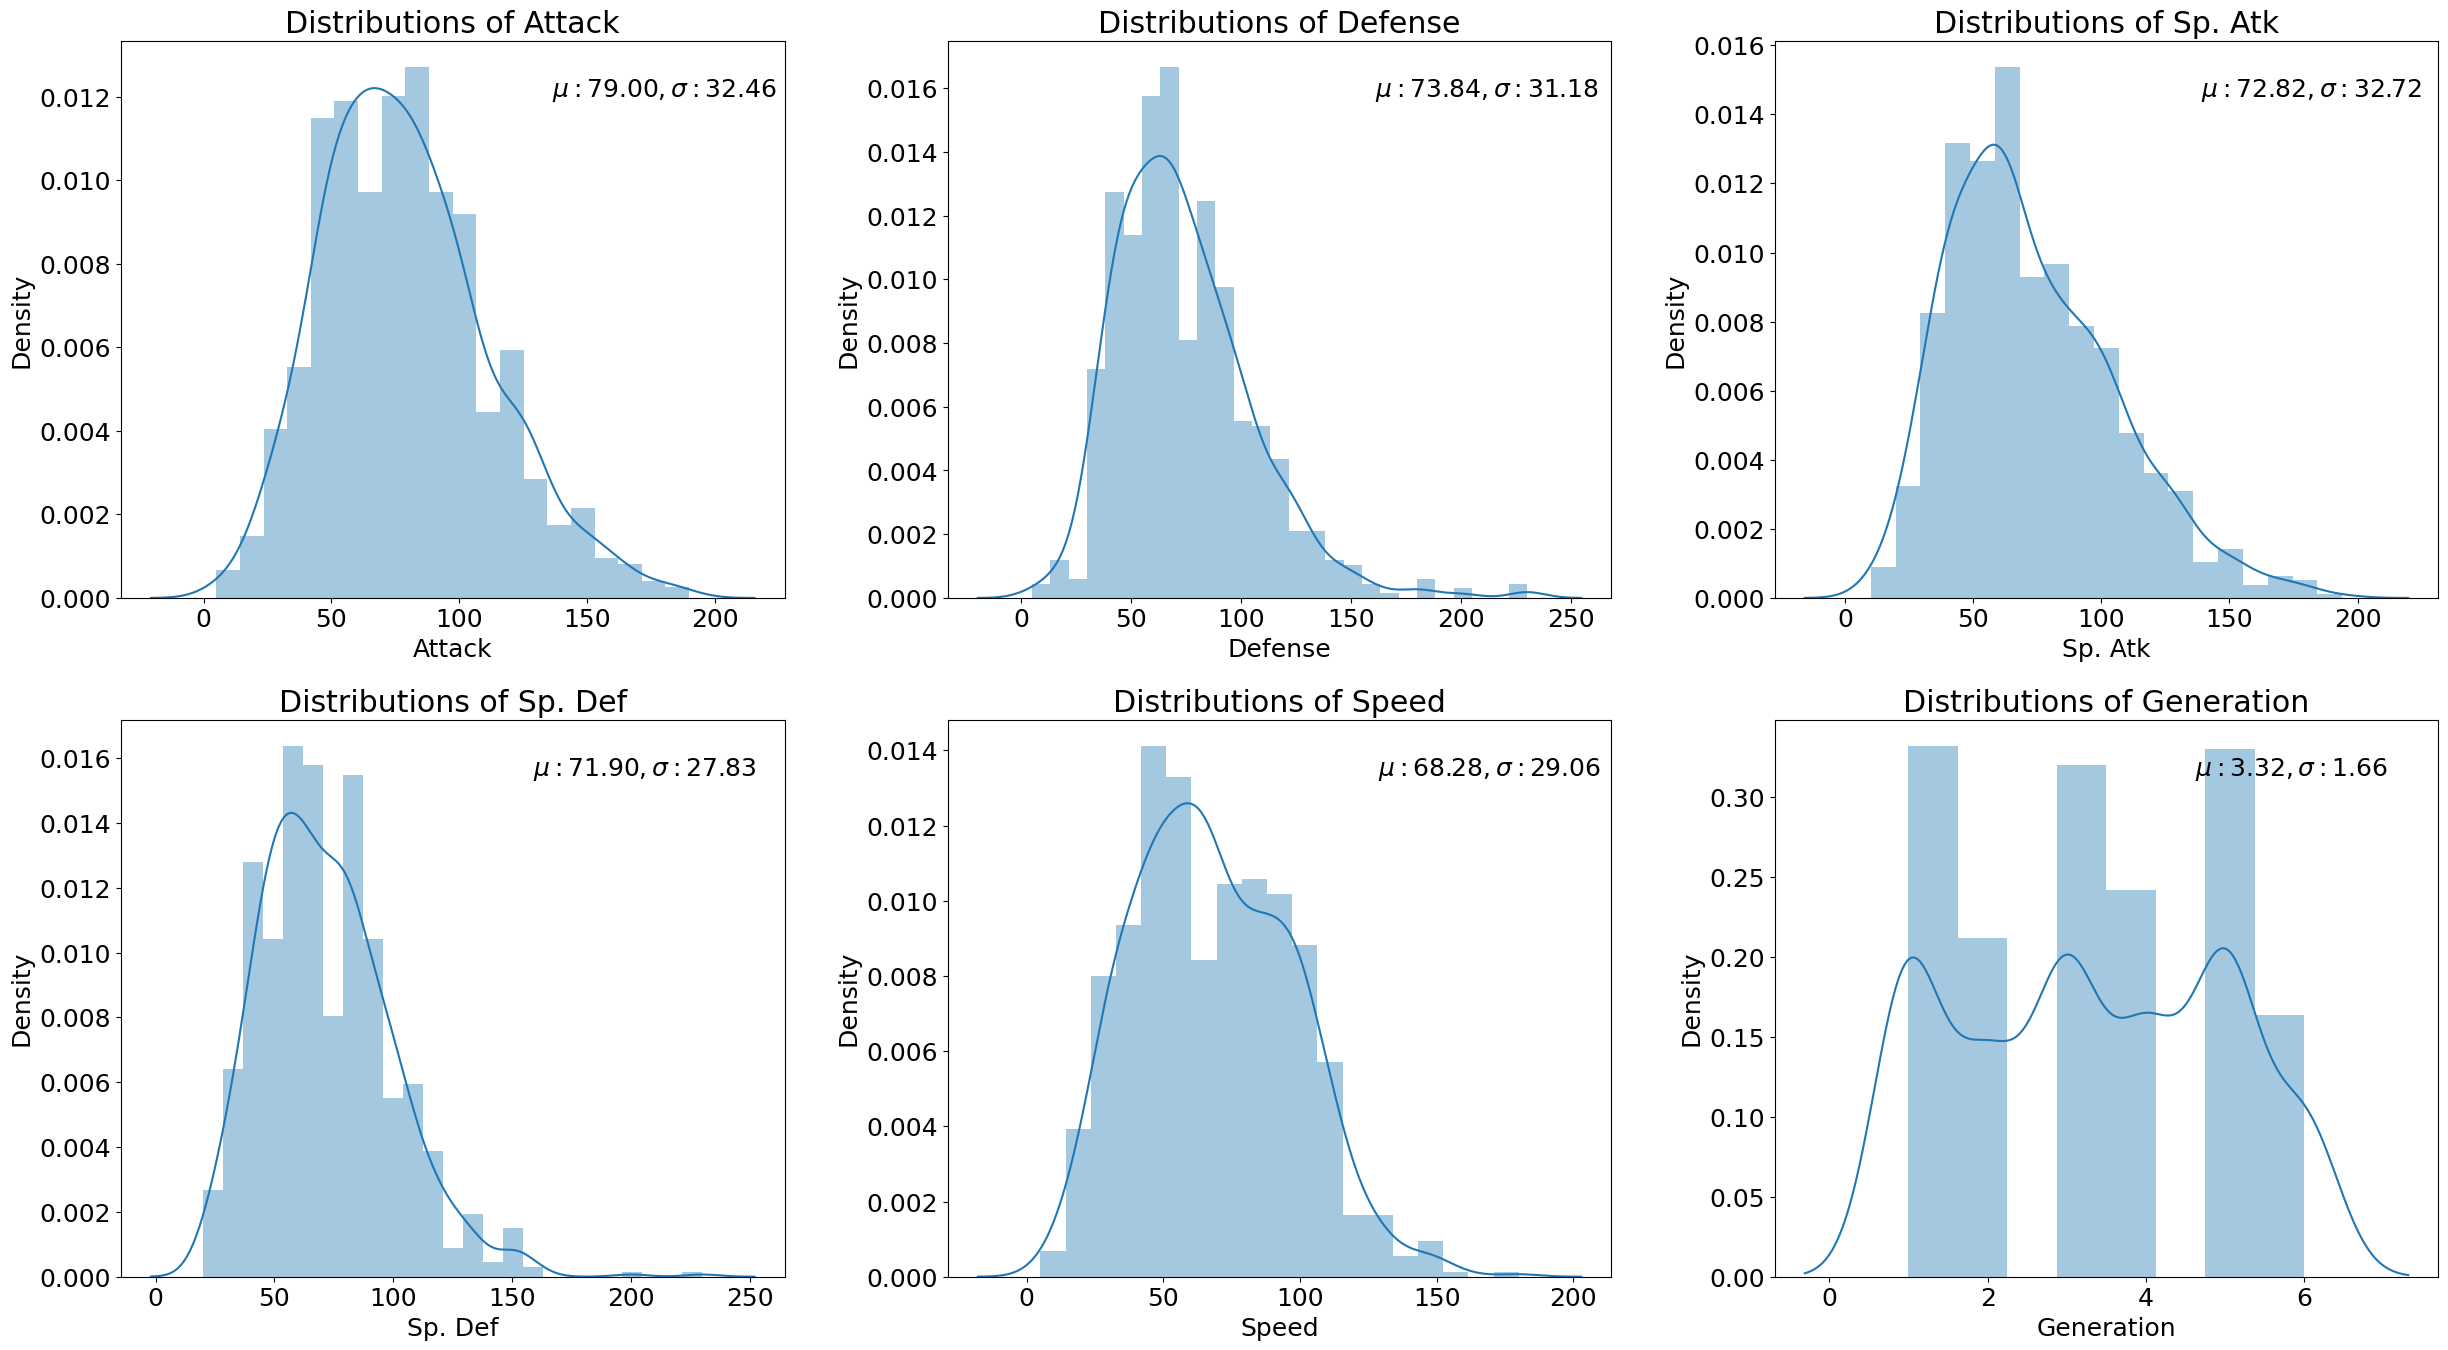

In [61]:
stats = pokemon.columns[5:11]
plt.figure(figsize=(25, 20))

for ii, stat in enumerate(stats):
    title = "Distributions of {stat}".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    sns.distplot(pokemon[stat])
    x = plt.gca().get_xlim()[1] * .6
    y = plt.gca().get_ylim()[1] * .9
    plt.text(x, y, '$\mu: {mu: .2f}, \sigma: {sigma: .2f}$'.format(mu = pokemon[stat].mean(), sigma=pokemon[stat].std()))
    
    
plt.tight_layout()
plt.show()

# Comparación entre tipos

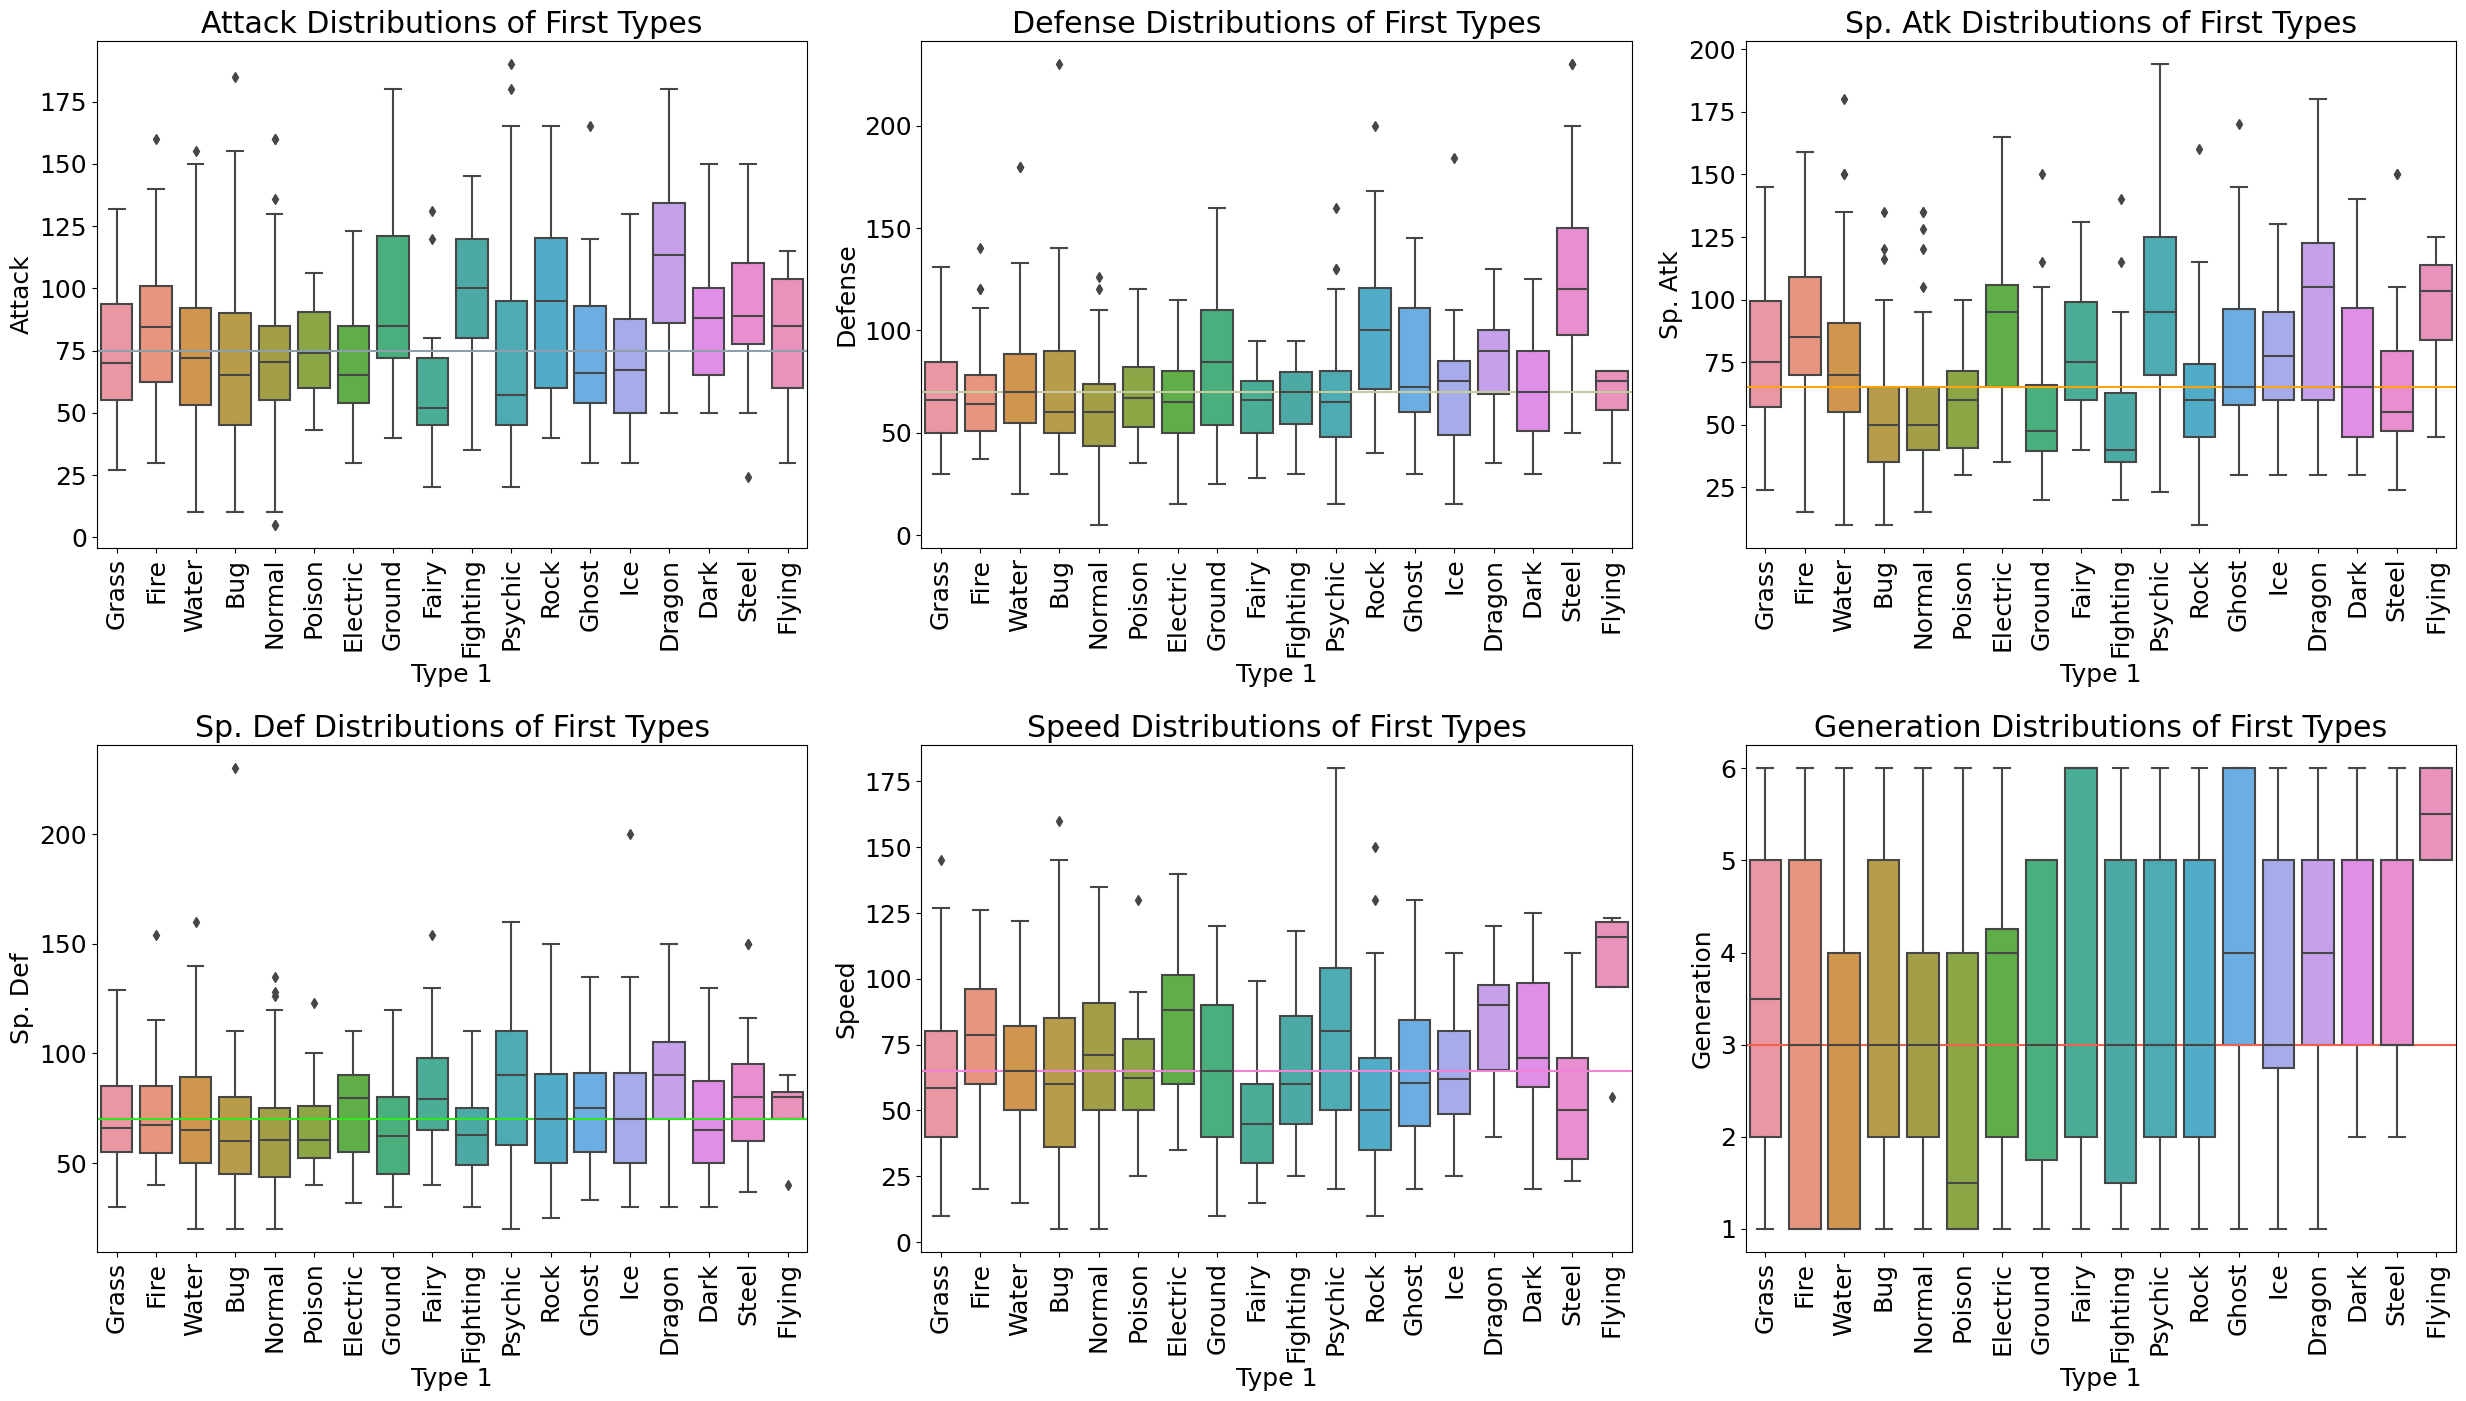

In [62]:
plt.figure(figsize=(25,20))

for ii, stat in enumerate(stats):
    title = "{stat} Distributions of First Types".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    plt.xticks(rotation=90)
    sns.boxplot(x='Type 1', y=stat, data = pokemon)
    plt.axhline(pokemon[stat].median(), color=np.random.rand(3))
    
plt.tight_layout()
plt.show()

--------
---------


## **Próximos pasos**

Se podrá hacer un clasificador de pokemon?

In [63]:
pokemons = pd.read_csv('https://raw.githubusercontent.com/MauricioRR-Tec/AprendizajeAutomatico/main/Tema_2_AnalisisEstadistico/data/pokemon2.csv')
numbers = []
for i in range(1,pokemons.shape[0]+1):
    numbers.append(i)
pokemons['pkn'] = numbers
IMG_DIR = 'C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]

In [64]:
import re
dataframe_img = pd.DataFrame([])
images = []
pokemon_number = []
for img in onlyfiles:
    if not re.search('-', img):
        pkn = img.split('.')
        n = re.sub("[^0-9]", "", pkn[0])
        path = IMG_DIR +'/' +str(img)
        images.append(path)
        pokemon_number.append(n)
dataframe_img['images'] = images
dataframe_img['pkn'] = pokemon_number
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
result = pokemons.merge(dataframe_img, left_on='pkn', right_on='pkn')
result.head()

Name  Type1   Type2  pkn  \
0   bulbasaur  Grass  Poison    1   
1     ivysaur  Grass  Poison    2   
2    venusaur  Grass  Poison    3   
3  charmander   Fire     NaN    4   
4  charmeleon   Fire     NaN    5   

                                              images  
0  C:/Users/beyon/Desktop/Materias 2021/Aprendiza...  
1  C:/Users/beyon/Desktop/Materias 2021/Aprendiza...  
2  C:/Users/beyon/Desktop/Materias 2021/Aprendiza...  
3  C:/Users/beyon/Desktop/Materias 2021/Aprendiza...  
4  C:/Users/beyon/Desktop/Materias 2021/Aprendiza...

In [65]:
result['Type1'].value_counts()

Water       103
Normal       91
Grass        64
Bug          61
Fire         47
Psychic      46
Rock         41
Electric     35
Ground       29
Dark         28
Poison       28
Fighting     25
Dragon       24
Ice          23
Steel        22
Ghost        22
Fairy        17
Flying        2
Name: Type1, dtype: int64

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


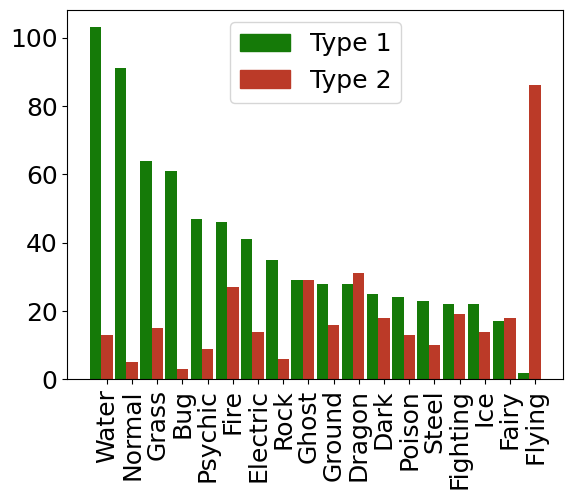

In [66]:
vals1 = [result['Type1'].value_counts()[key] for key in result['Type1'].value_counts().index]
vals2 = [result['Type2'].value_counts()[key] for key in result['Type1'].value_counts().index]
inds = np.arange(len(result['Type1'].value_counts().index))
width = .45
color1 = np.random.rand(3)
color2 = np.random.rand(3)
handles = [patches.Patch(color=color1, label='Type 1'), patches.Patch(color=color2, label='Type 2')]
plt.bar(inds, vals1, width, color=color1)
plt.bar(inds+width, vals2, width, color=color2)
plt.gca().set_xticklabels(pokemon['Type 1'].value_counts().index)
plt.gca().set_xticks(inds+width)
plt.xticks(rotation=90)
plt.legend(handles=handles)

In [67]:
select = ['Water', 'Fire']
result = result[result['Type1'].isin(select)]

In [68]:
result['Type1'].value_counts()

Water    103
Fire      47
Name: Type1, dtype: int64

In [69]:
import os
from shutil import copyfile
os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/train/')
os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/test/')
os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/val/')
for class_ in result['Type1'].unique():
    os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/train/'+str(class_)+'/')
    os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/test/'+str(class_)+'/')
    os.mkdir('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/val/'+str(class_)+'/')

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    result, result['Type1'],test_size=0.33, stratify=result['Type1'])

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33,stratify=y_test)

In [71]:
from shutil import copyfile, copy2

for image,type_  in zip(X_train['images'], y_train):
    copy2(image, 'C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/train/'+type_)

for image,type_ in zip(X_test['images'], y_test):
    copy2(image, 'C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/test/'+type_)
    
for image,type_ in zip(X_val['images'], y_val):
    copy2(image, 'C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/val/'+type_)

In [72]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/train/')
test = datagen.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/test/')
val = datagen.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/val/')

C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1ty

Found 100 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [73]:
y_test.size

33

In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator

def build():
    model = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    model.summary()
    return model
model = build()
history = model.fit_generator(train, epochs=30, validation_data=val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 255, 32)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        2

In [75]:
predict = model.predict_generator(test)

Instructions for updating:
Please use Model.predict, which supports generators.


In [76]:
from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

              precision    recall  f1-score   support

        Fire       0.00      0.00      0.00        11
       Water       0.62      0.82      0.71        22

    accuracy                           0.55        33
   macro avg       0.31      0.41      0.35        33
weighted avg       0.41      0.55      0.47        33



In [77]:
def show_wrong_classification(y_test, predict, result):
    tmp = result[result.index.isin(y_test.index)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(tmp['images'], tmp['Type1'], predict):
        if true==pred:
            if i <3:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title(str(pred))
                i+=1

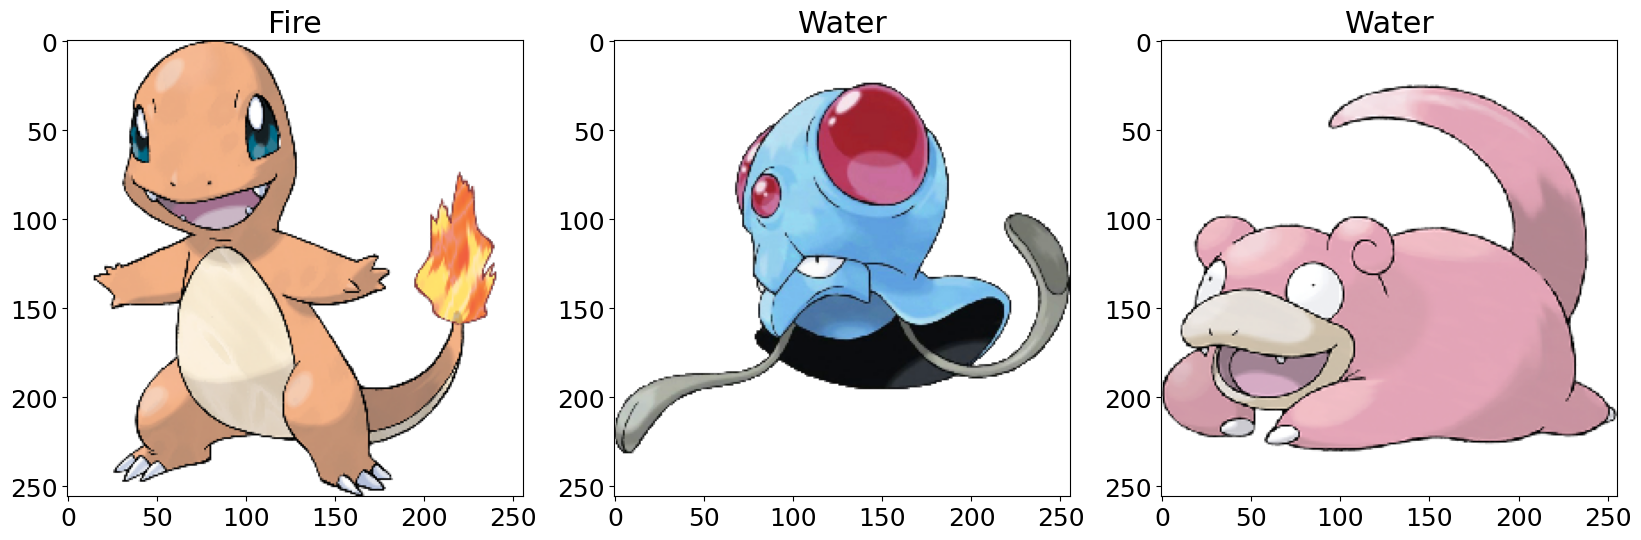

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [78]:
from PIL import Image
show_wrong_classification(y_test, predict_frame['category'], result)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-le

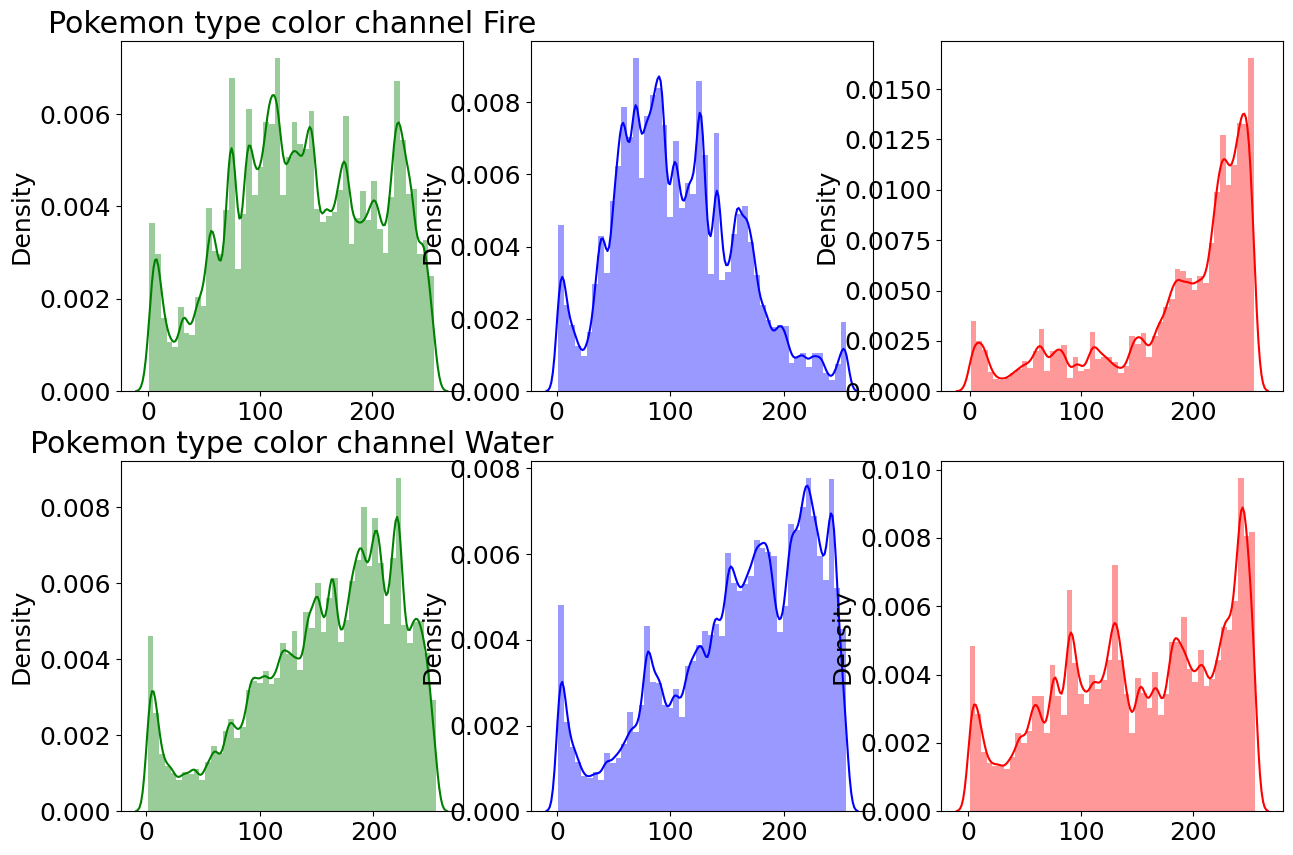

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3,figsize=(15,10))
k =0
import cv2
list_b =[]
list_r = []
list_g = []
from tqdm import tqdm
for type_ in tqdm(result['Type1'].unique()):
    tmp = result[result['Type1']==type_]
    for img in tmp['images']:
        img = cv2.imread(img)
        b, g, r = cv2.split(img)
        color = 'blue'
        for i in b:
            for j in i:
                if j != 0:
                    list_b.append(j)
        color = 'green'
        for i in g:
            for j in i:
                if j != 0:
                    list_g.append(j)
        color = 'red'
        for i in r:
            for j in i:
                if j != 0:
                    list_r.append(j)
    sns.distplot(list_g, ax=axes[k, 0], color='g')
    sns.distplot(list_b, ax=axes[k, 1], color='b')
    sns.distplot(list_r, ax=axes[k, 2], color='r')
    axes[k, 0].set_title('Pokemon type color channel ' + type_)
    if type_ =='Fire':
        list_g_f = list_g
        list_b_f = list_b
        list_r_f = list_r
    else:
        list_g_w = list_g
        list_b_w = list_b
        list_r_w = list_r
    list_b =[]
    list_r = []
    list_g = []
    
    k += 1

**USAR ESTAS LINEAS CON PRECAUCIÓN** 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

g_fire = np.std(np.array(list_g_f), axis=0)
r_fire = np.std(np.array(list_r_f), axis=0)
b_fire = np.std(np.array(list_b_f), axis=0)


g_water = np.std(np.array(list_g_w), axis=0)
r_water = np.std(np.array(list_r_w), axis=0)
b_water = np.std(np.array(list_b_w), axis=0)

fig = make_subplots(rows=1, cols=2, subplot_titles=("Fire std channel","Water std channel"))
fig.add_trace(go.Scatter(
    y=[b_fire, g_fire, g_fire],
    x=['blue', 'green', 'red'],
    mode='markers',
    marker=dict(size=[b_fire, g_fire, r_fire],
                color=['blue', 'green', 'red'],
                showscale=True)
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=[b_water, g_water, r_water],
    x=['blue', 'green', 'red'],
    mode='markers',
    marker=dict(size=[b_water, g_water, r_water],
                color=['blue', 'green', 'red'],
                showscale=True)
), row=1, col=2)
fig.update_layout(showlegend=False)
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'width': 850, 
        'height': 400

})
fig.show()

---
---
---

In [80]:
water = result[result['Type1']=='Water']
stds = []
values = []
for image in water['images']:
    img = cv2.imread(image)
    b, g, r = cv2.split(img)
    for i in r:
        for j in i:
            if j != 0:
                stds.append(j)       
    std = np.mean(np.array(stds), axis=0)
    values.append(std)
    stds = []
water['stds'] = values

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
water = water.sort_values(by='stds', ascending=False)

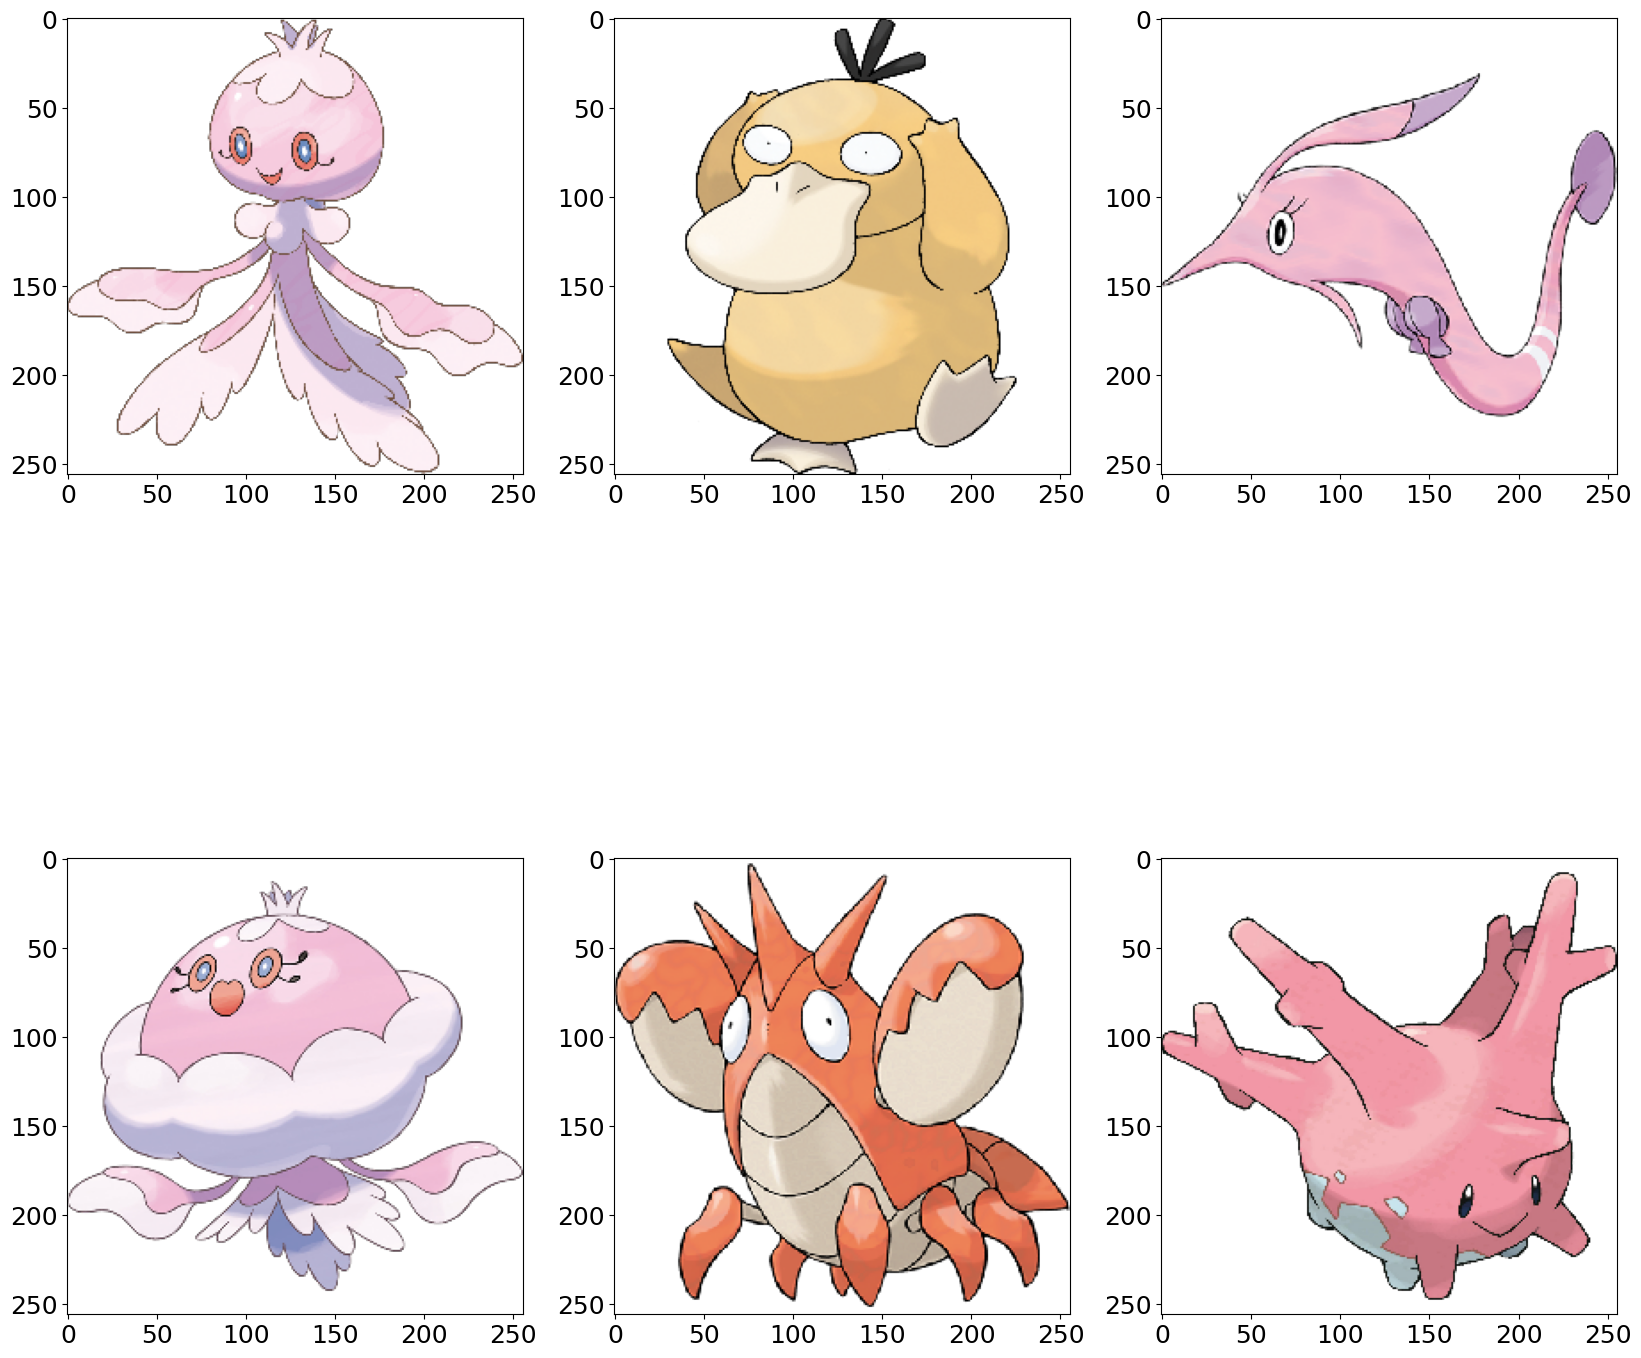

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [82]:
i = 0
j = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for imag in water['images']:
    if i == 1 and j ==3:
        break
    if j > 2:
        i =1
        j = 0
    img = Image.open(imag)
    fig = plt.figure()
    ax[i][j].imshow(img)
    j+=1

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


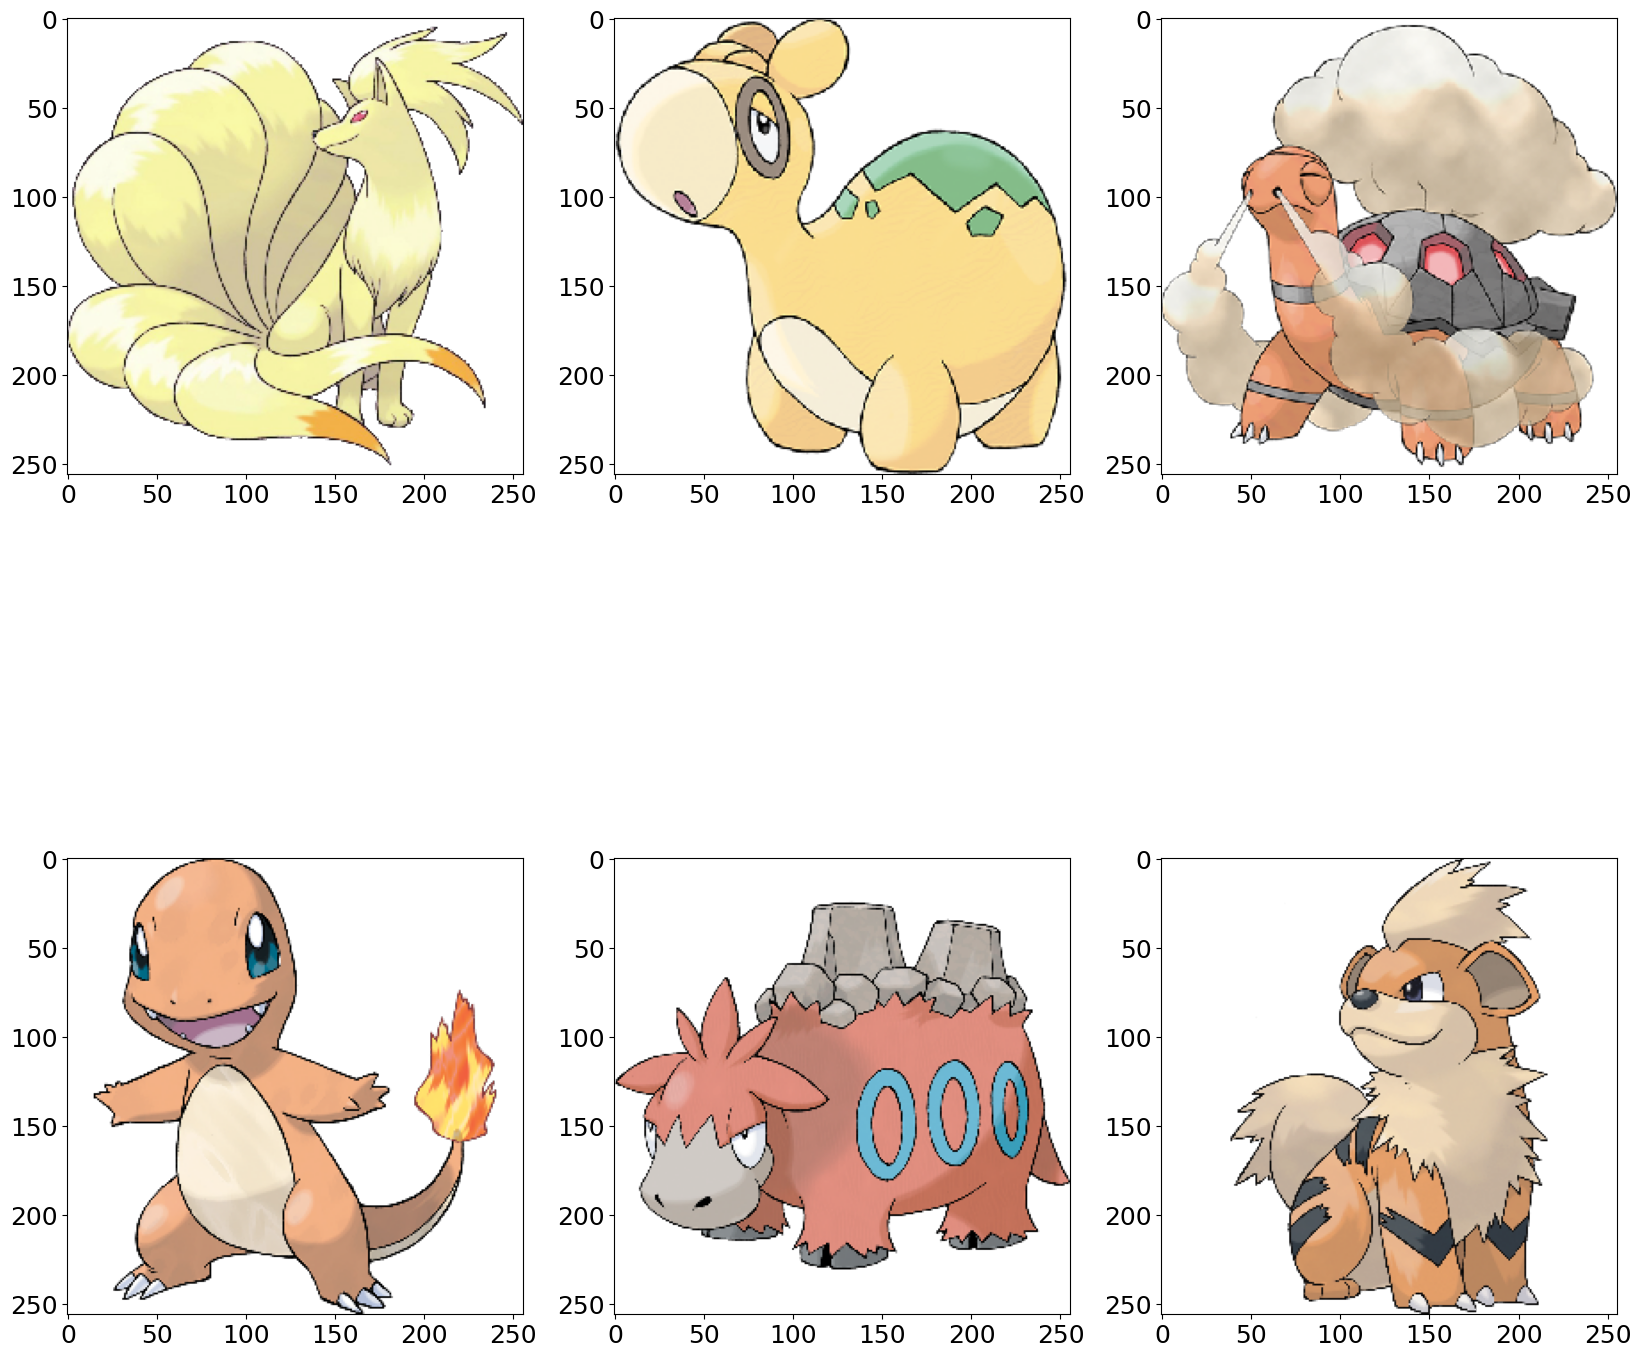

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [83]:
fire = result[result['Type1']=='Fire']
stds = []
values = []
for image in fire['images']:
    img = cv2.imread(image)
    b, g, r = cv2.split(img)
    for i in b:
        for j in i:
            if j != 0:
                stds.append(j)       
    std = np.mean(np.array(stds), axis=0)
    values.append(std)
    stds = []
fire['stds'] = values
fire = fire.sort_values(by='stds', ascending=False)
i = 0
j = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for imag in fire['images']:
    if i == 1 and j ==3:
        break
    if j > 2:
        i =1
        j = 0
    img = Image.open(imag)
    fig = plt.figure()
    ax[i][j].imshow(img)
    j+=1

## Aumento de datos

    Para intentar mejorar nuestro resultado, aplicaré algo de aumento de imagen.

* brillo



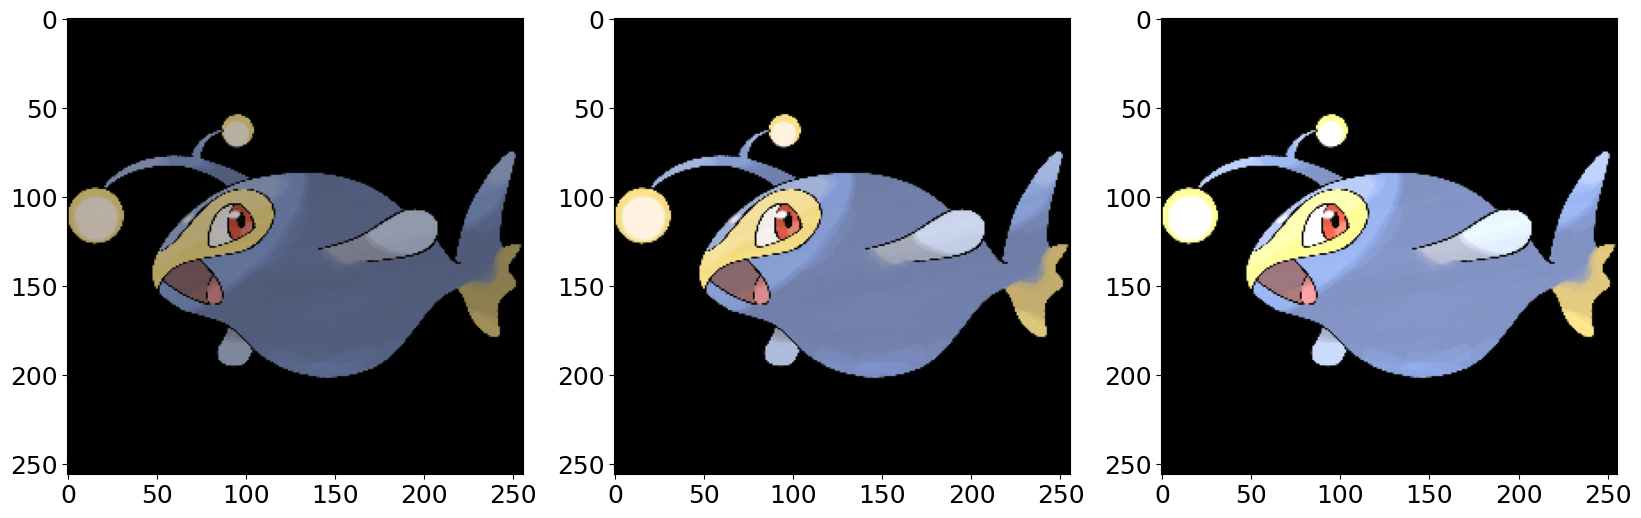

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [84]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
img = load_img(water['images'][170])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(brightness_range=[0.2,1.5])
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

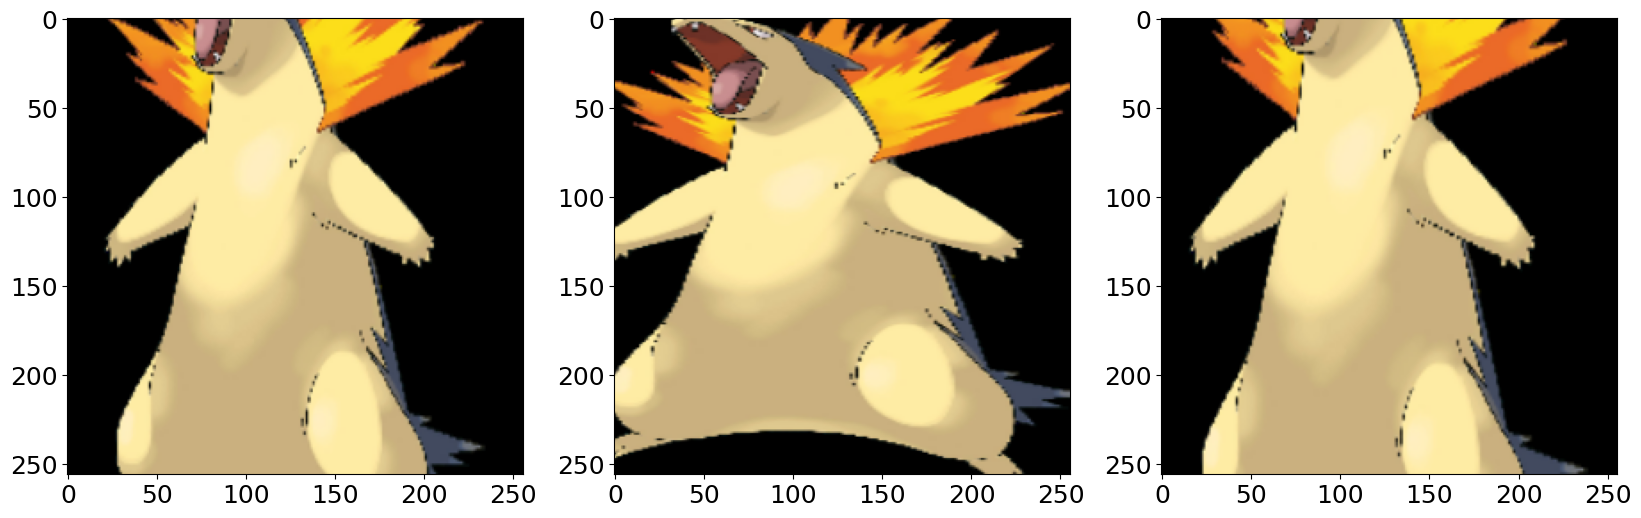

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [85]:
# Zoom
img = load_img(fire['images'][156])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(zoom_range=[0.5, 1.0])
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

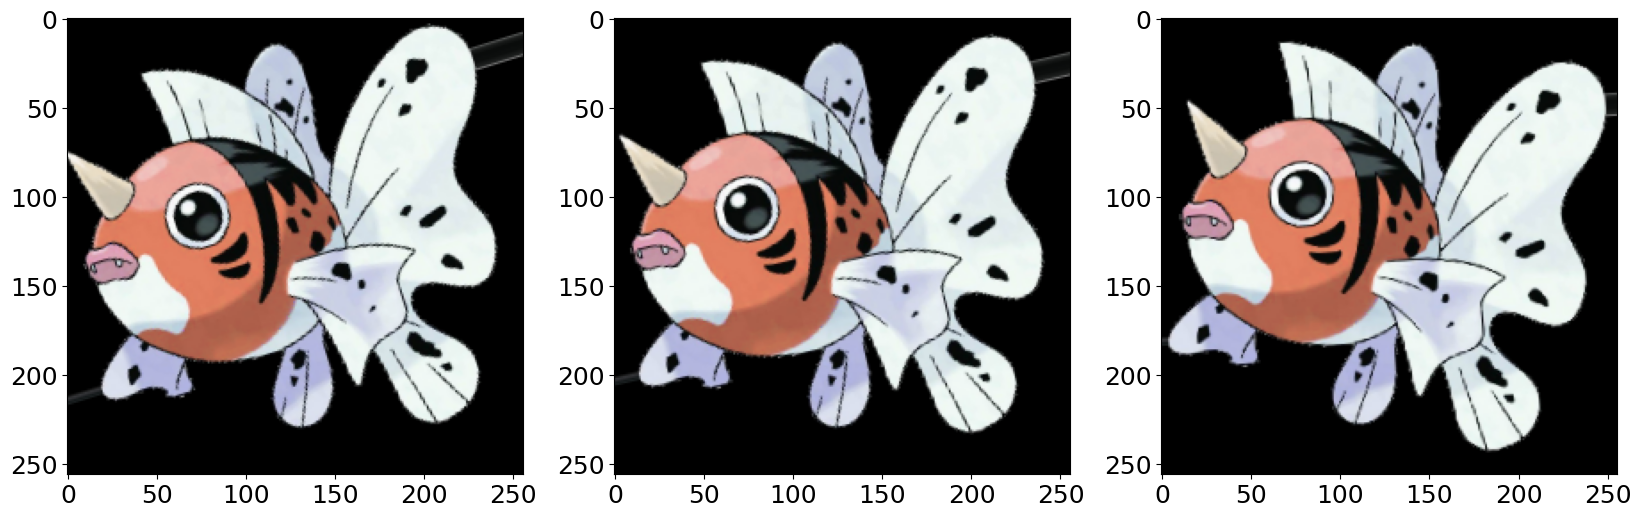

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [86]:
# Rotacion
img = load_img(water['images'][118])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(rotation_range=35)
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

In [87]:
datagentrain = ImageDataGenerator(rotation_range=35, 
                                 zoom_range=[0.5, 1.0], 
                                 brightness_range=[0.2,1.5])

datagen = ImageDataGenerator()

train = datagentrain.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/train/')
test = datagen.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/test/')
val = datagen.flow_from_directory('C:/Users/beyon/Desktop/Materias 2021/AprendizajeAutomatico/Tema_2_AnalisisEstadistico/data/pokemon2/val/')

Found 100 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [88]:
model = build()
history = model.fit_generator(train, epochs=30, validation_data=val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
batch_normalization_4 (Batch (None, 255, 255, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 84, 84, 64)        8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 84, 84, 64)       

In [89]:
predict_frame = pd.DataFrame([])
predict = model.predict_generator(test)
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

              precision    recall  f1-score   support

        Fire       0.00      0.00      0.00        11
       Water       0.67      1.00      0.80        22

    accuracy                           0.67        33
   macro avg       0.33      0.50      0.40        33
weighted avg       0.44      0.67      0.53        33



C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


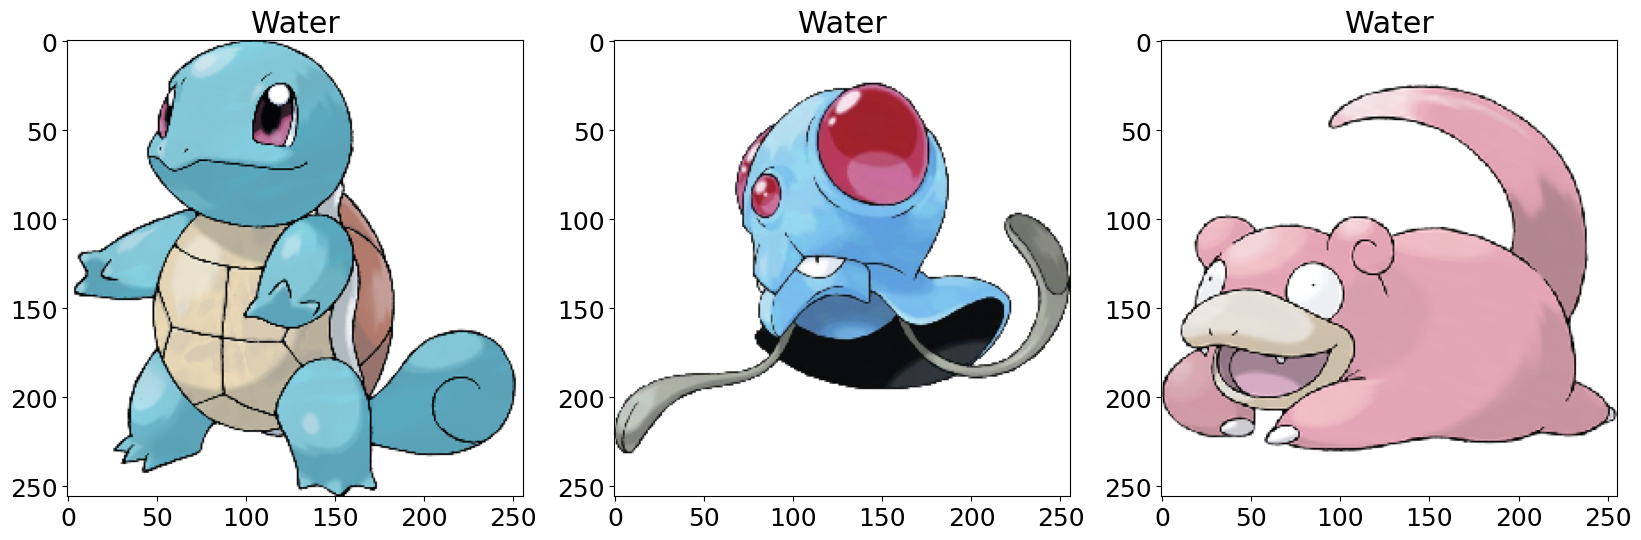

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [90]:
show_wrong_classification(y_test, predict_frame['category'], result)


Por lo tanto, una clasificación de los Pokémon de tipo fuego se ve afectada debido a que el canal rojo de los Pokémon de tipo agua es muy difícil de realizar la clasificación correctamente incluso con el aumento.